# Amplitude Source Location (ASL)

## 1. Introduction

### 1.1 Review

In the previous tutorial, we estimated Reduced Displacement by assuming a source location, e.g. the summit of a volcano. But it would be better if we locate volcano-seismic signals, and then compute Reduced Displacement. Most volcano-seismic signals cannot be located using traditional differential travel-time techniques, because they lack identifiable phases (sources are quasi-continuous, so phases are arriving all the time). So what else can we do?

### 1.2 Motivation
In summer 1996, I was fortunate enough as a graduate student to be asked to assist the British Geological Survey in its monitoring of the Soufriere Hills Volcano, Montserrat. As part of "Team Seismic" at the Montserrat Volcano Observatory, our job was to provide 24-7 monitoring of the lava dome eruption, which had been continuous since October 1995. Crucially, this involved two-way radio communications with others working on the slopes of the volcano, and warning them of seismicity, especially pyroclastic flows [Add video here from Lauren's Journeys program]. 

I had the idea that we could use the RSAM data to locate seismicity continuously, on a map on a monitor in the Ops Room. I created a proof-of-concept, using the 60-s RSAM data (the 2.56-s RSAM data wasn't captured) to locate tremor. And then later applied it to triggered event files for rockfalls and pyroclastic flows. We will replicate that here using Displacement Seismic Amplitude Measurement data, which is like RSAM that has been instrument-corrected. For simplicity - and speed which was important for a real-time system - we ignore the vertical dimension (topography and station elevations ignored), and assume an isotropic, homogeneous half-space.

First, we will run a simulation, to demonstrate that our location technique works, showing that we can simulate a set of source locations, and then recover them with our location technique. Then we will compute locations for real DSAM data, and then for a known pyroclastic flow signal. For the latter, we will use a 5-s moving window, which we shift by 1-s through the whole length of the signal.

### 1.3 Caveats

I call the approach above "naive" ASL, because for simplicity (and speed, for real-time application) it ignores the vertical dimension, and assumes a homogeneous, isotropic half space (1-layer). It also considers the seismic source to be a point source, and assumes only one event is occurring at a time. In reality, pyroclastic flows cause multiple seismic sources per unit time, over an extended area, and this evolves with time as the flow moves downhill. Moreover, there can be numerous pyroclastic flows travelling down different flanks of the volcano at the same time, such as in a major dome collapse which may be comprised of dozens of pyroclastic flows that reach the coast. This ASL technique can only estimate an average location of all seismicity recorded in each time window.


### 1.4 Setup

We need to import the following, to set things up.


In [1]:
import os
import sys
from pathlib import Path
import numpy as np
import obspy
from flovopy.processing.sam import DSAM
from flovopy.analysis.asl import topo_map, Grid, ASL, simulate_SAM, plot_SAM, synthetic_source_from_grid, compare_asl_sources
SDS_DIR = Path.cwd().joinpath('data','continuous','SDS')
SAM_DIR = Path.cwd().joinpath('data','continuous','SAM')
DEM_DIR = Path.cwd().joinpath('data','DEMs')
RESPONSE_DIR = Path.cwd().joinpath('data','responses')

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams["figure.dpi"] = 150  # more pixels per inch


## 2. Synthetic testing

### 2.1 Map of Montserrat stations
We generate a map of seismic stations with a vertical-component sensor, operational (though not necessarily working properly) on July 12, 2003. This 13-station network provides good azimuthal coverage.

topo_map: region=[np.float64(-62.28141496683029), np.float64(-62.07258503316971), 16.621, 16.821]


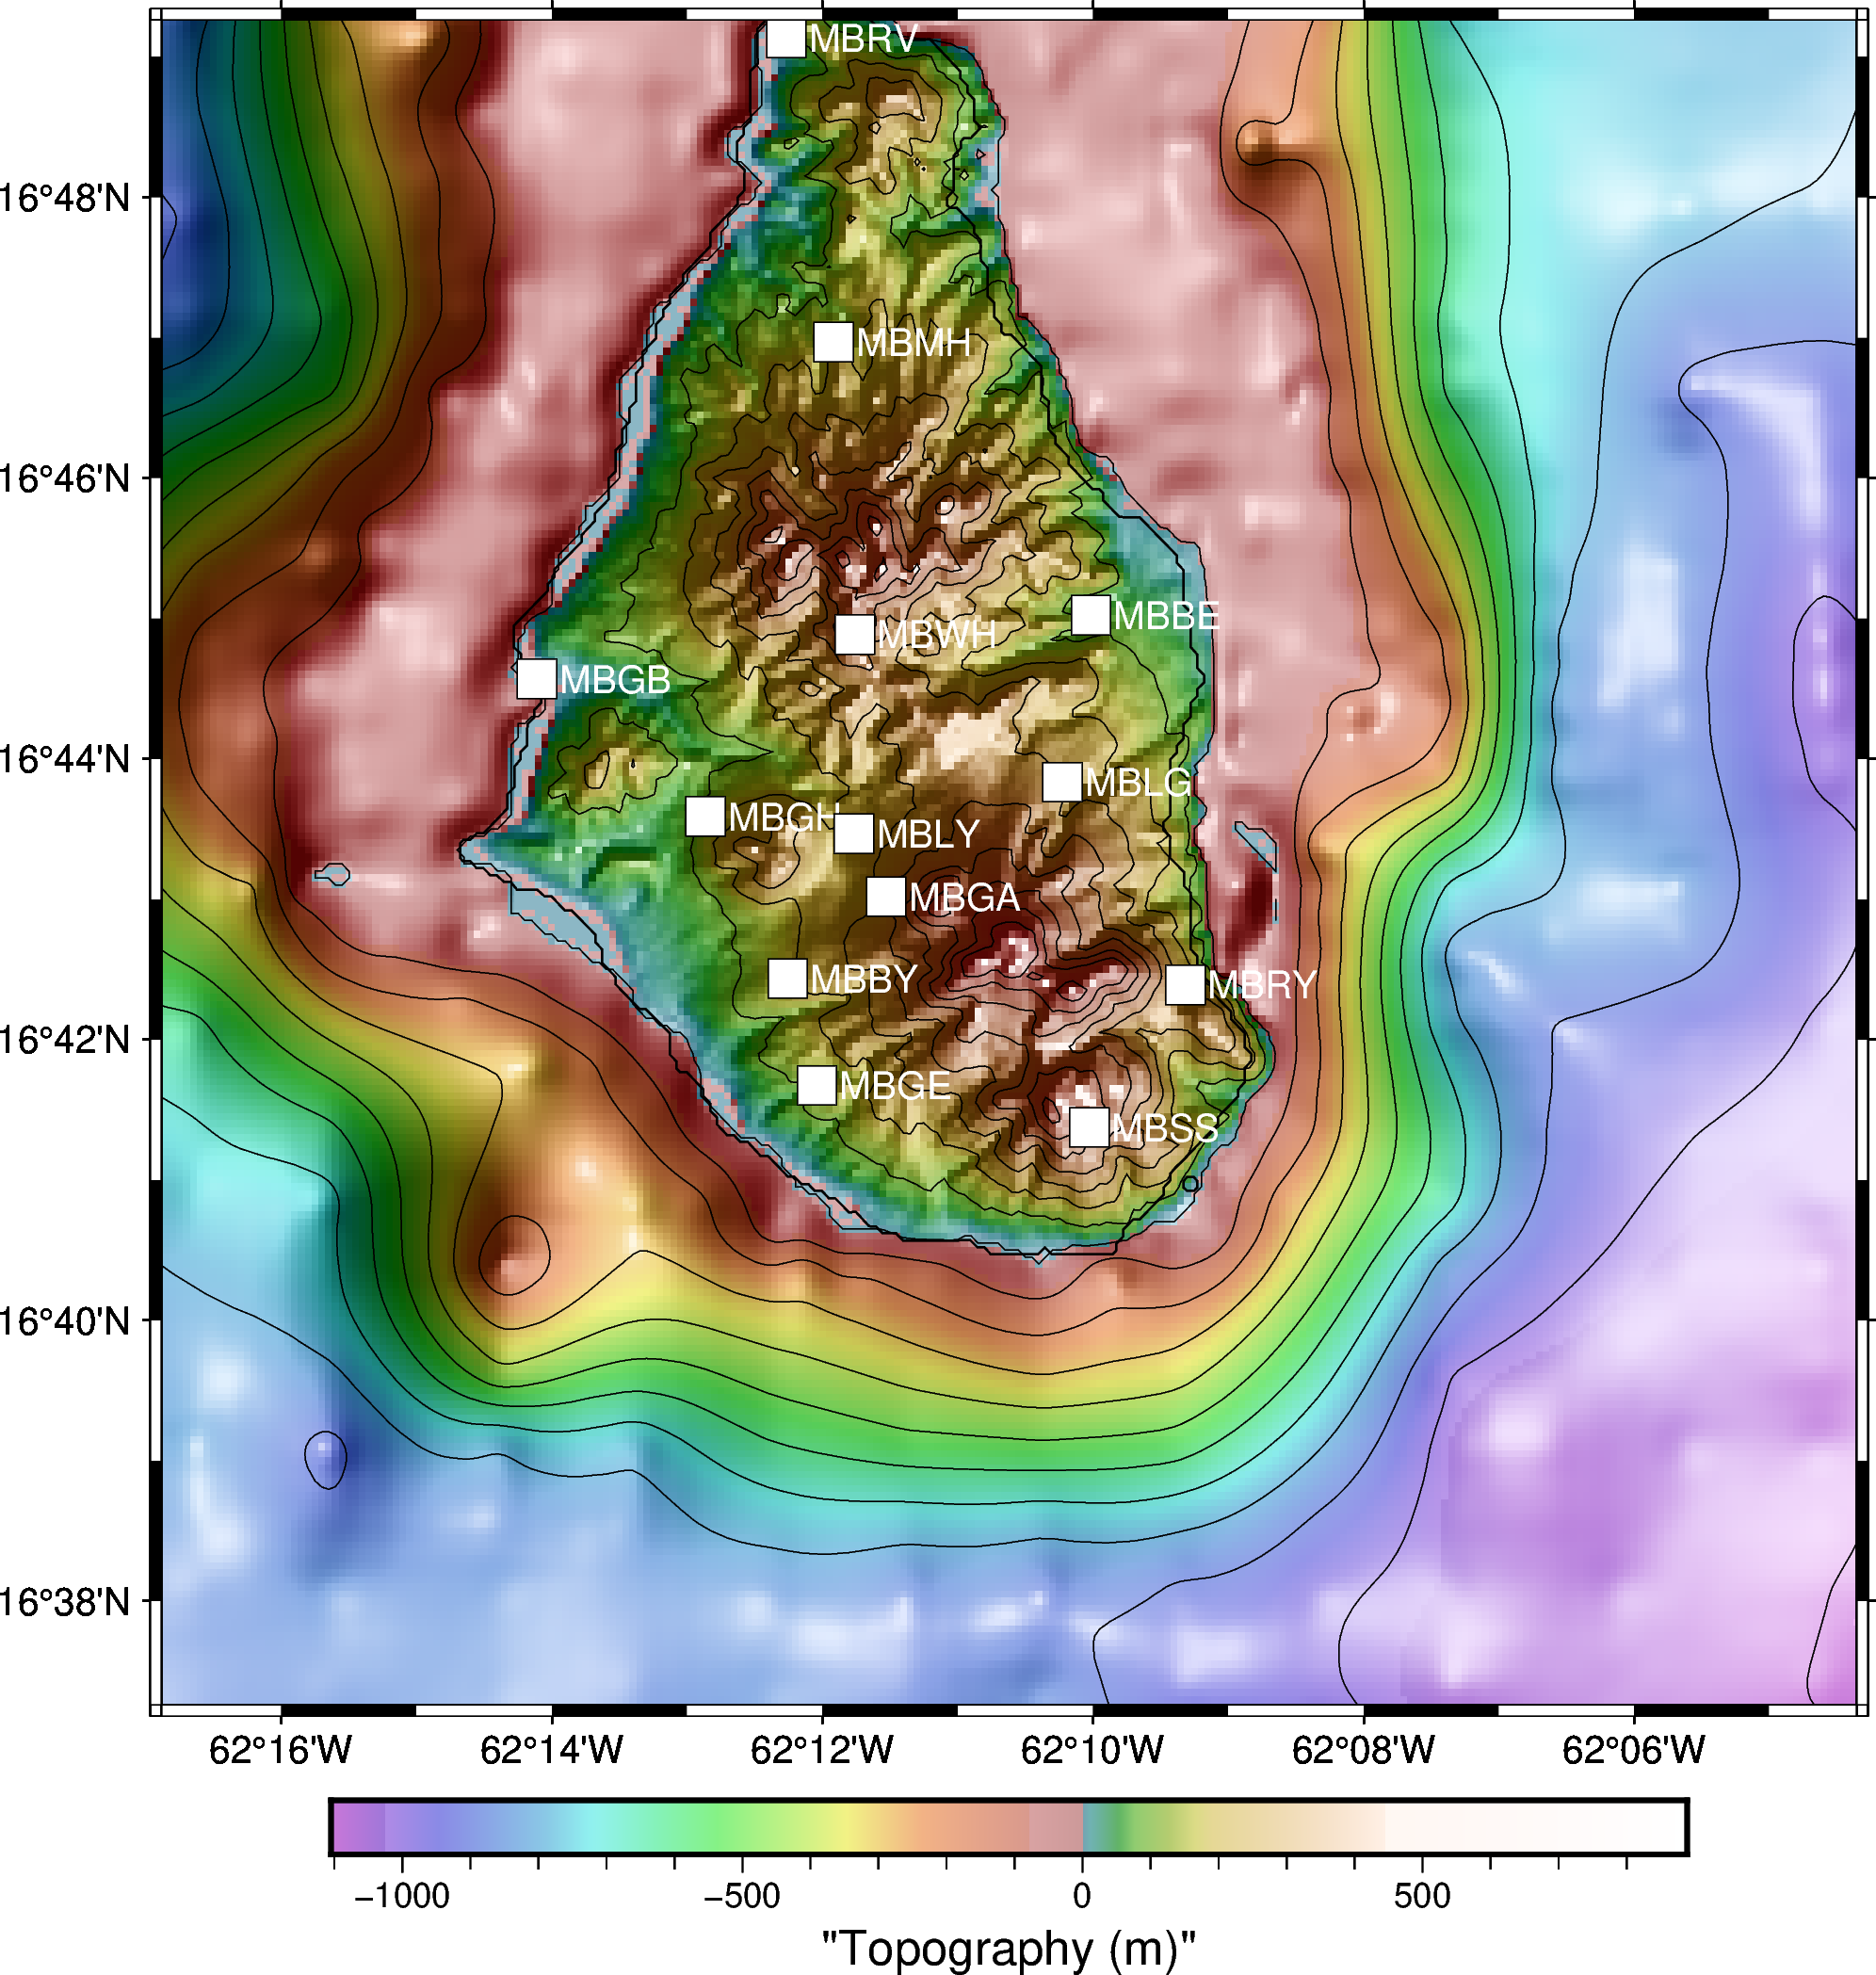

In [2]:
invMVO = obspy.read_inventory(os.path.join(RESPONSE_DIR,'MV.xml'), format='stationxml')
startt = obspy.UTCDateTime(2003,7,12,23,0,0)
endt = obspy.UTCDateTime(2003,7,13,4,0,0)
invMVO = invMVO.select(starttime=startt, endtime=endt)
invMVO = invMVO.select(channel='*Z')
topo_map(inv=invMVO, show=True, add_labels=True, resolution='03s', DEM_DIR=DEM_DIR);

### 2.2 Define a grid of source locations and reduced displacement at those nodes

topo_map: region=[np.float64(-62.22340665192458), np.float64(-62.13059334807542), 16.676555555555556, 16.765444444444444]


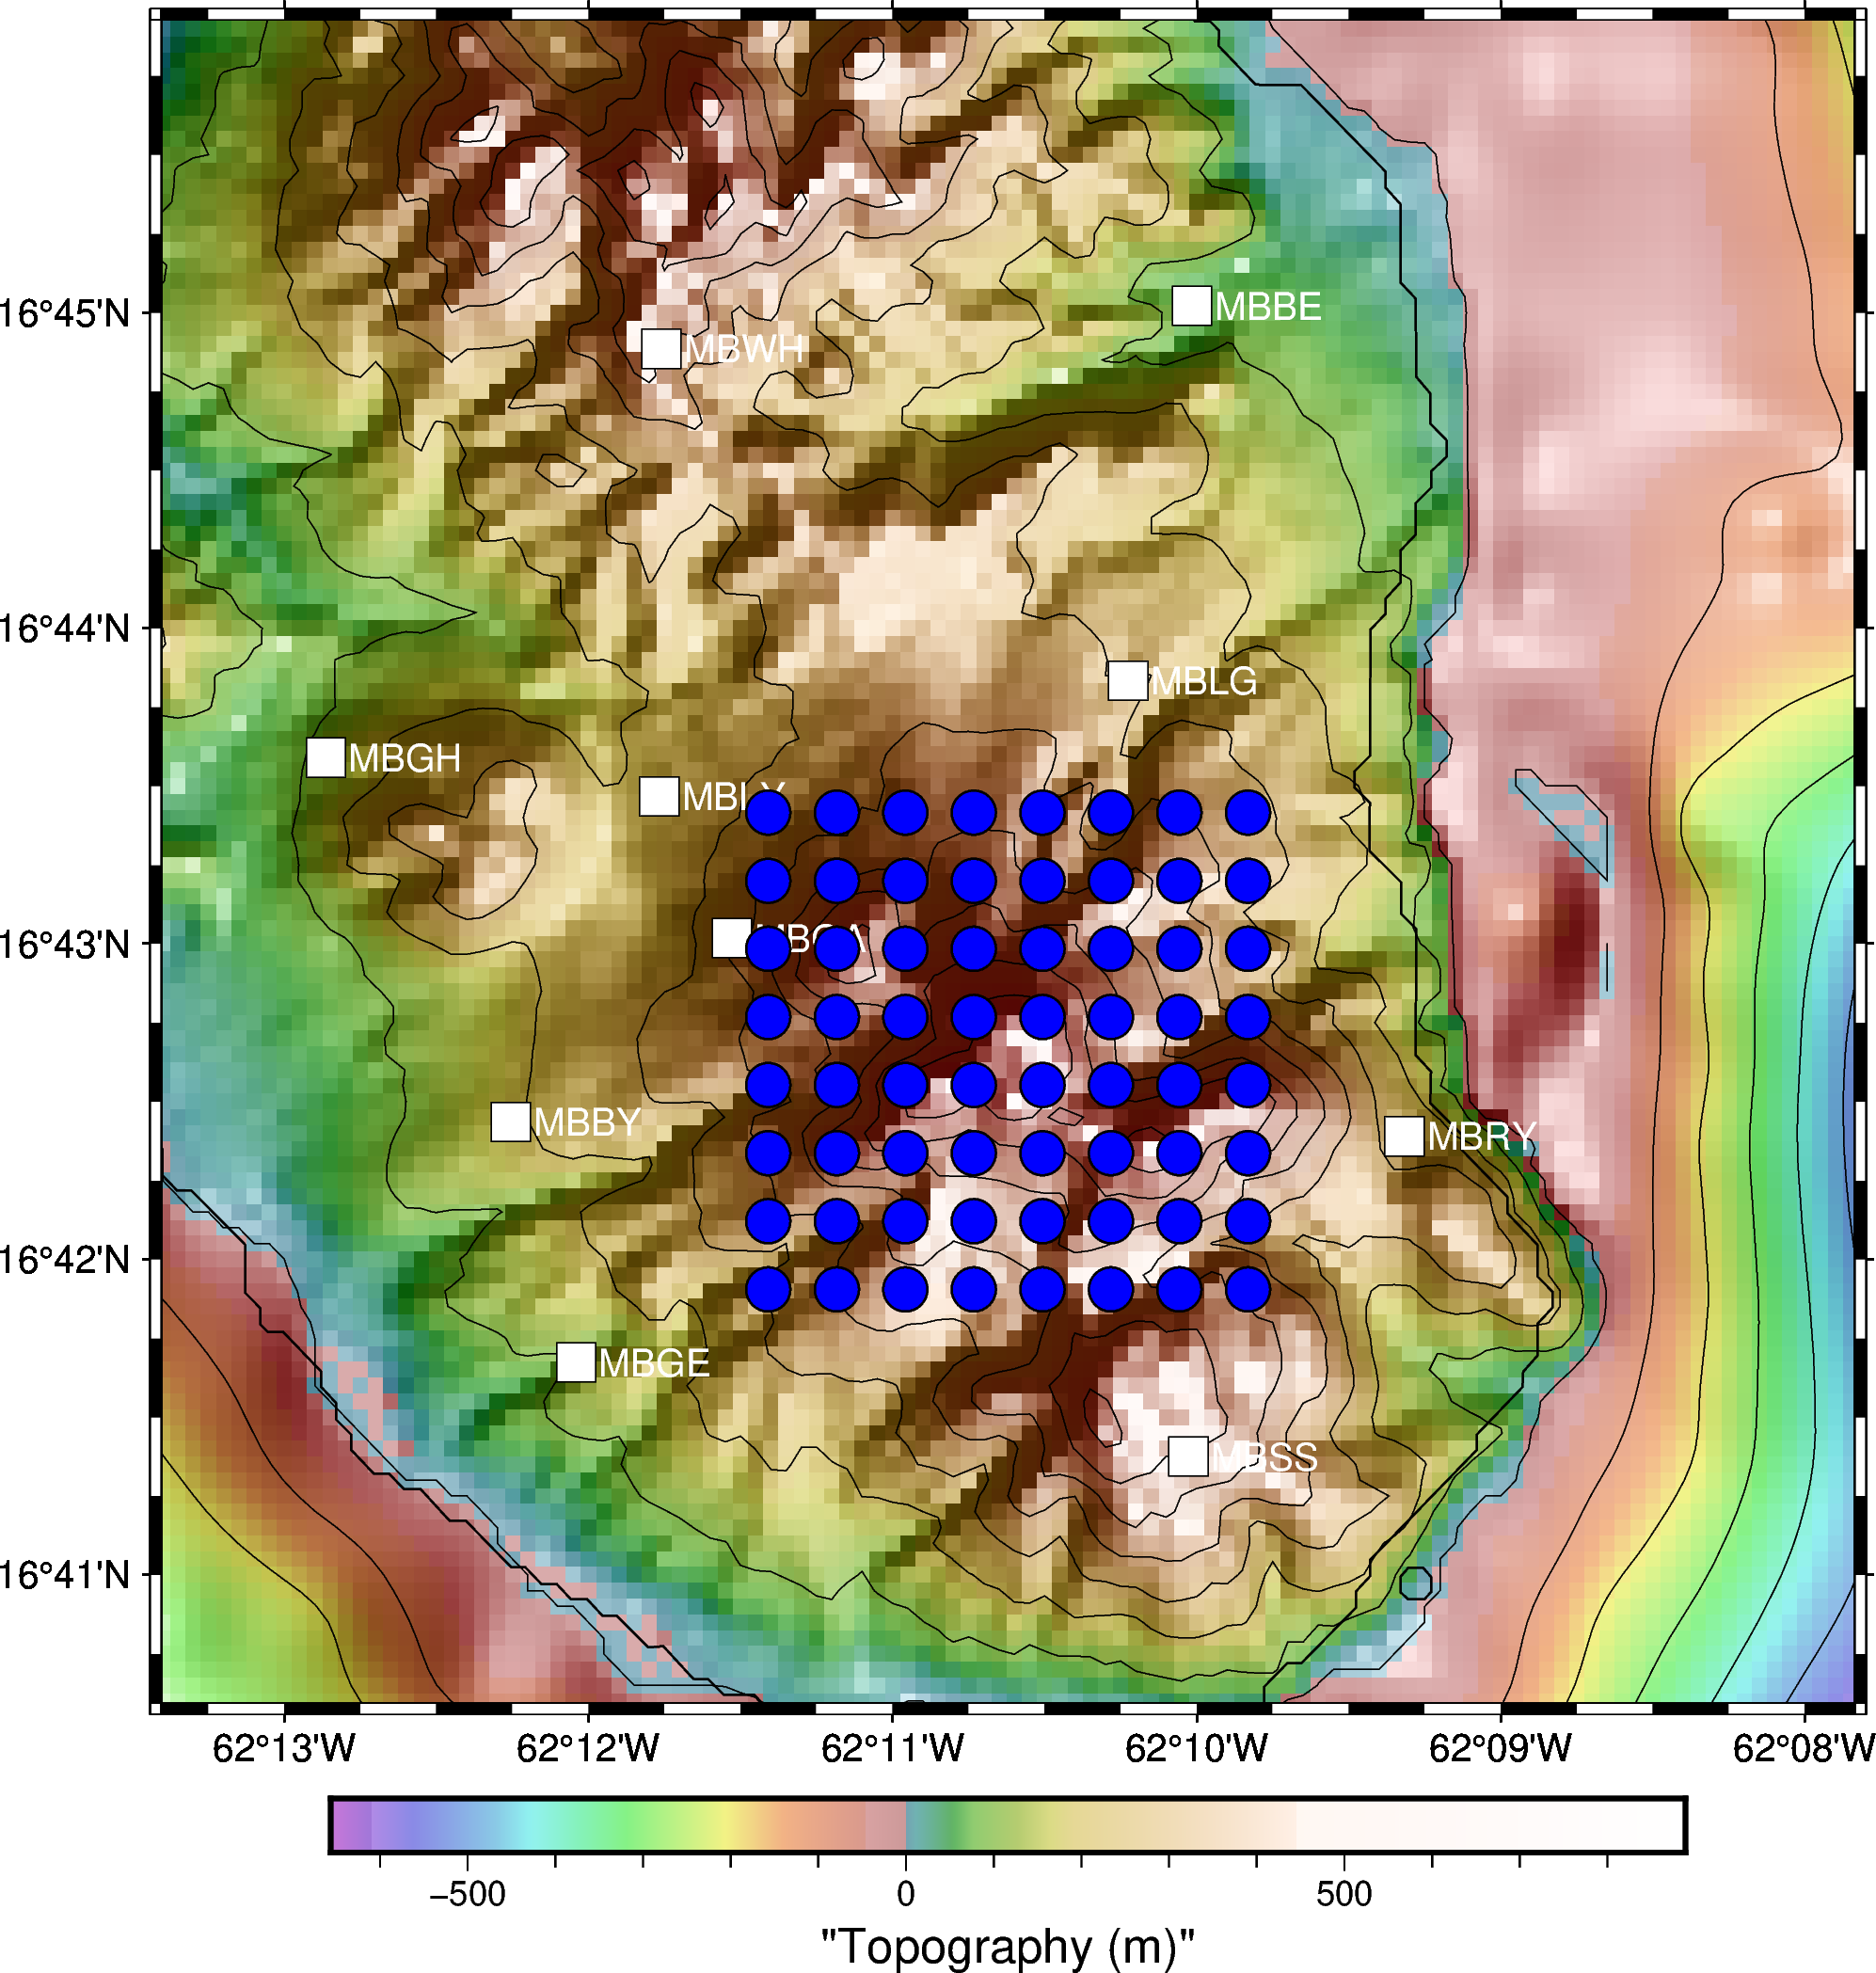

METRIC: mean


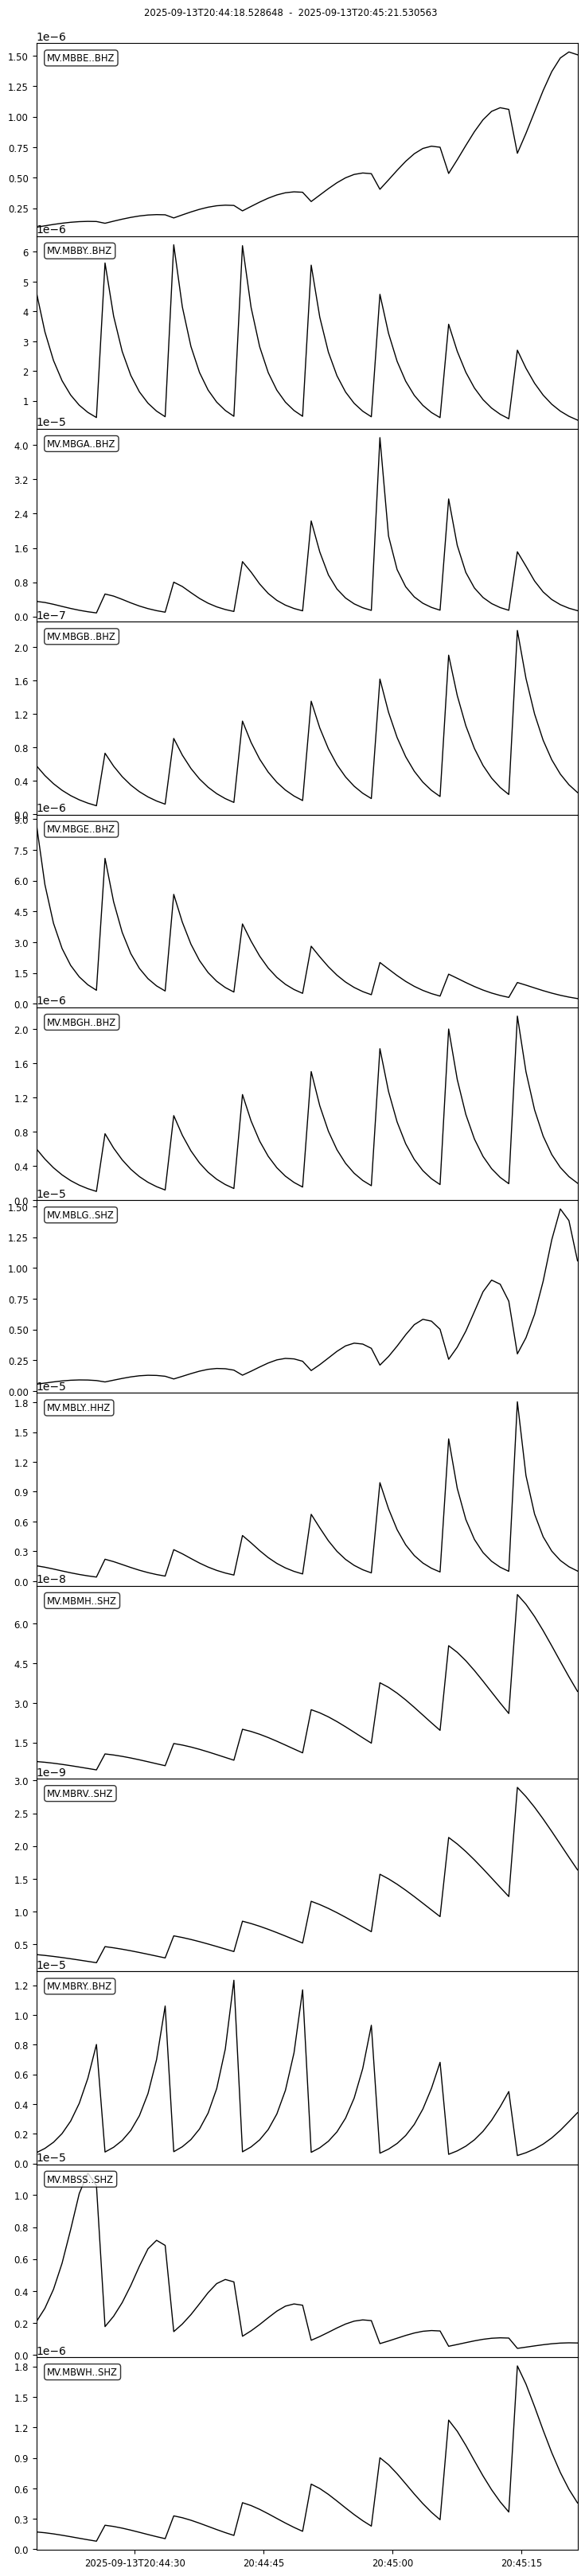

In [3]:
# params
sampling_interval = 1.0  # seconds, to simulate moving window

# grid params
node_spacing_m = 400
nlat = 8   # 11
nlon = 8   # 11
centerlat =  16.711
centerlon =  -62.177

gridobj = Grid(centerlat, centerlon, nlat, nlon, node_spacing_m)
topo_map_args = {'inv':invMVO, 'DEM_DIR':DEM_DIR, 'add_labels':True, 'zoom_level':2}
gridobj.plot(scale=2, symbol='c', topo_map_kwargs=topo_map_args)

synthetic_source = synthetic_source_from_grid(
    gridobj,
    sampling_interval=sampling_interval,
    DR_cm2=100.0,
    t0=obspy.UTCDateTime(0),
    order="C",
)

surfaceWaveSpeed_kms = 1.5
peakf = 8.0
Q = 23

synthVSAMobj = simulate_SAM(
    invMVO,
    synthetic_source,
    units='m/s',
    surfaceWaves=True,
    wavespeed_kms=surfaceWaveSpeed_kms,
    peakf=peakf,
    Q=Q,
    noise_level_percent=0.0,
    verbose=True,
)
synthVSAMobj.plot(metrics="mean")

['MV.MBBE..BHZ', 'MV.MBBY..BHZ', 'MV.MBGA..BHZ', 'MV.MBGB..BHZ', 'MV.MBGE..BHZ', 'MV.MBGH..BHZ', 'MV.MBLG..SHZ', 'MV.MBLY..HHZ', 'MV.MBMH..SHZ', 'MV.MBRV..SHZ', 'MV.MBRY..BHZ', 'MV.MBSS..SHZ', 'MV.MBWH..SHZ']
topo_map: region=[np.float64(-62.28140949400923), np.float64(-62.07259050599077), 16.610999999999997, 16.811]


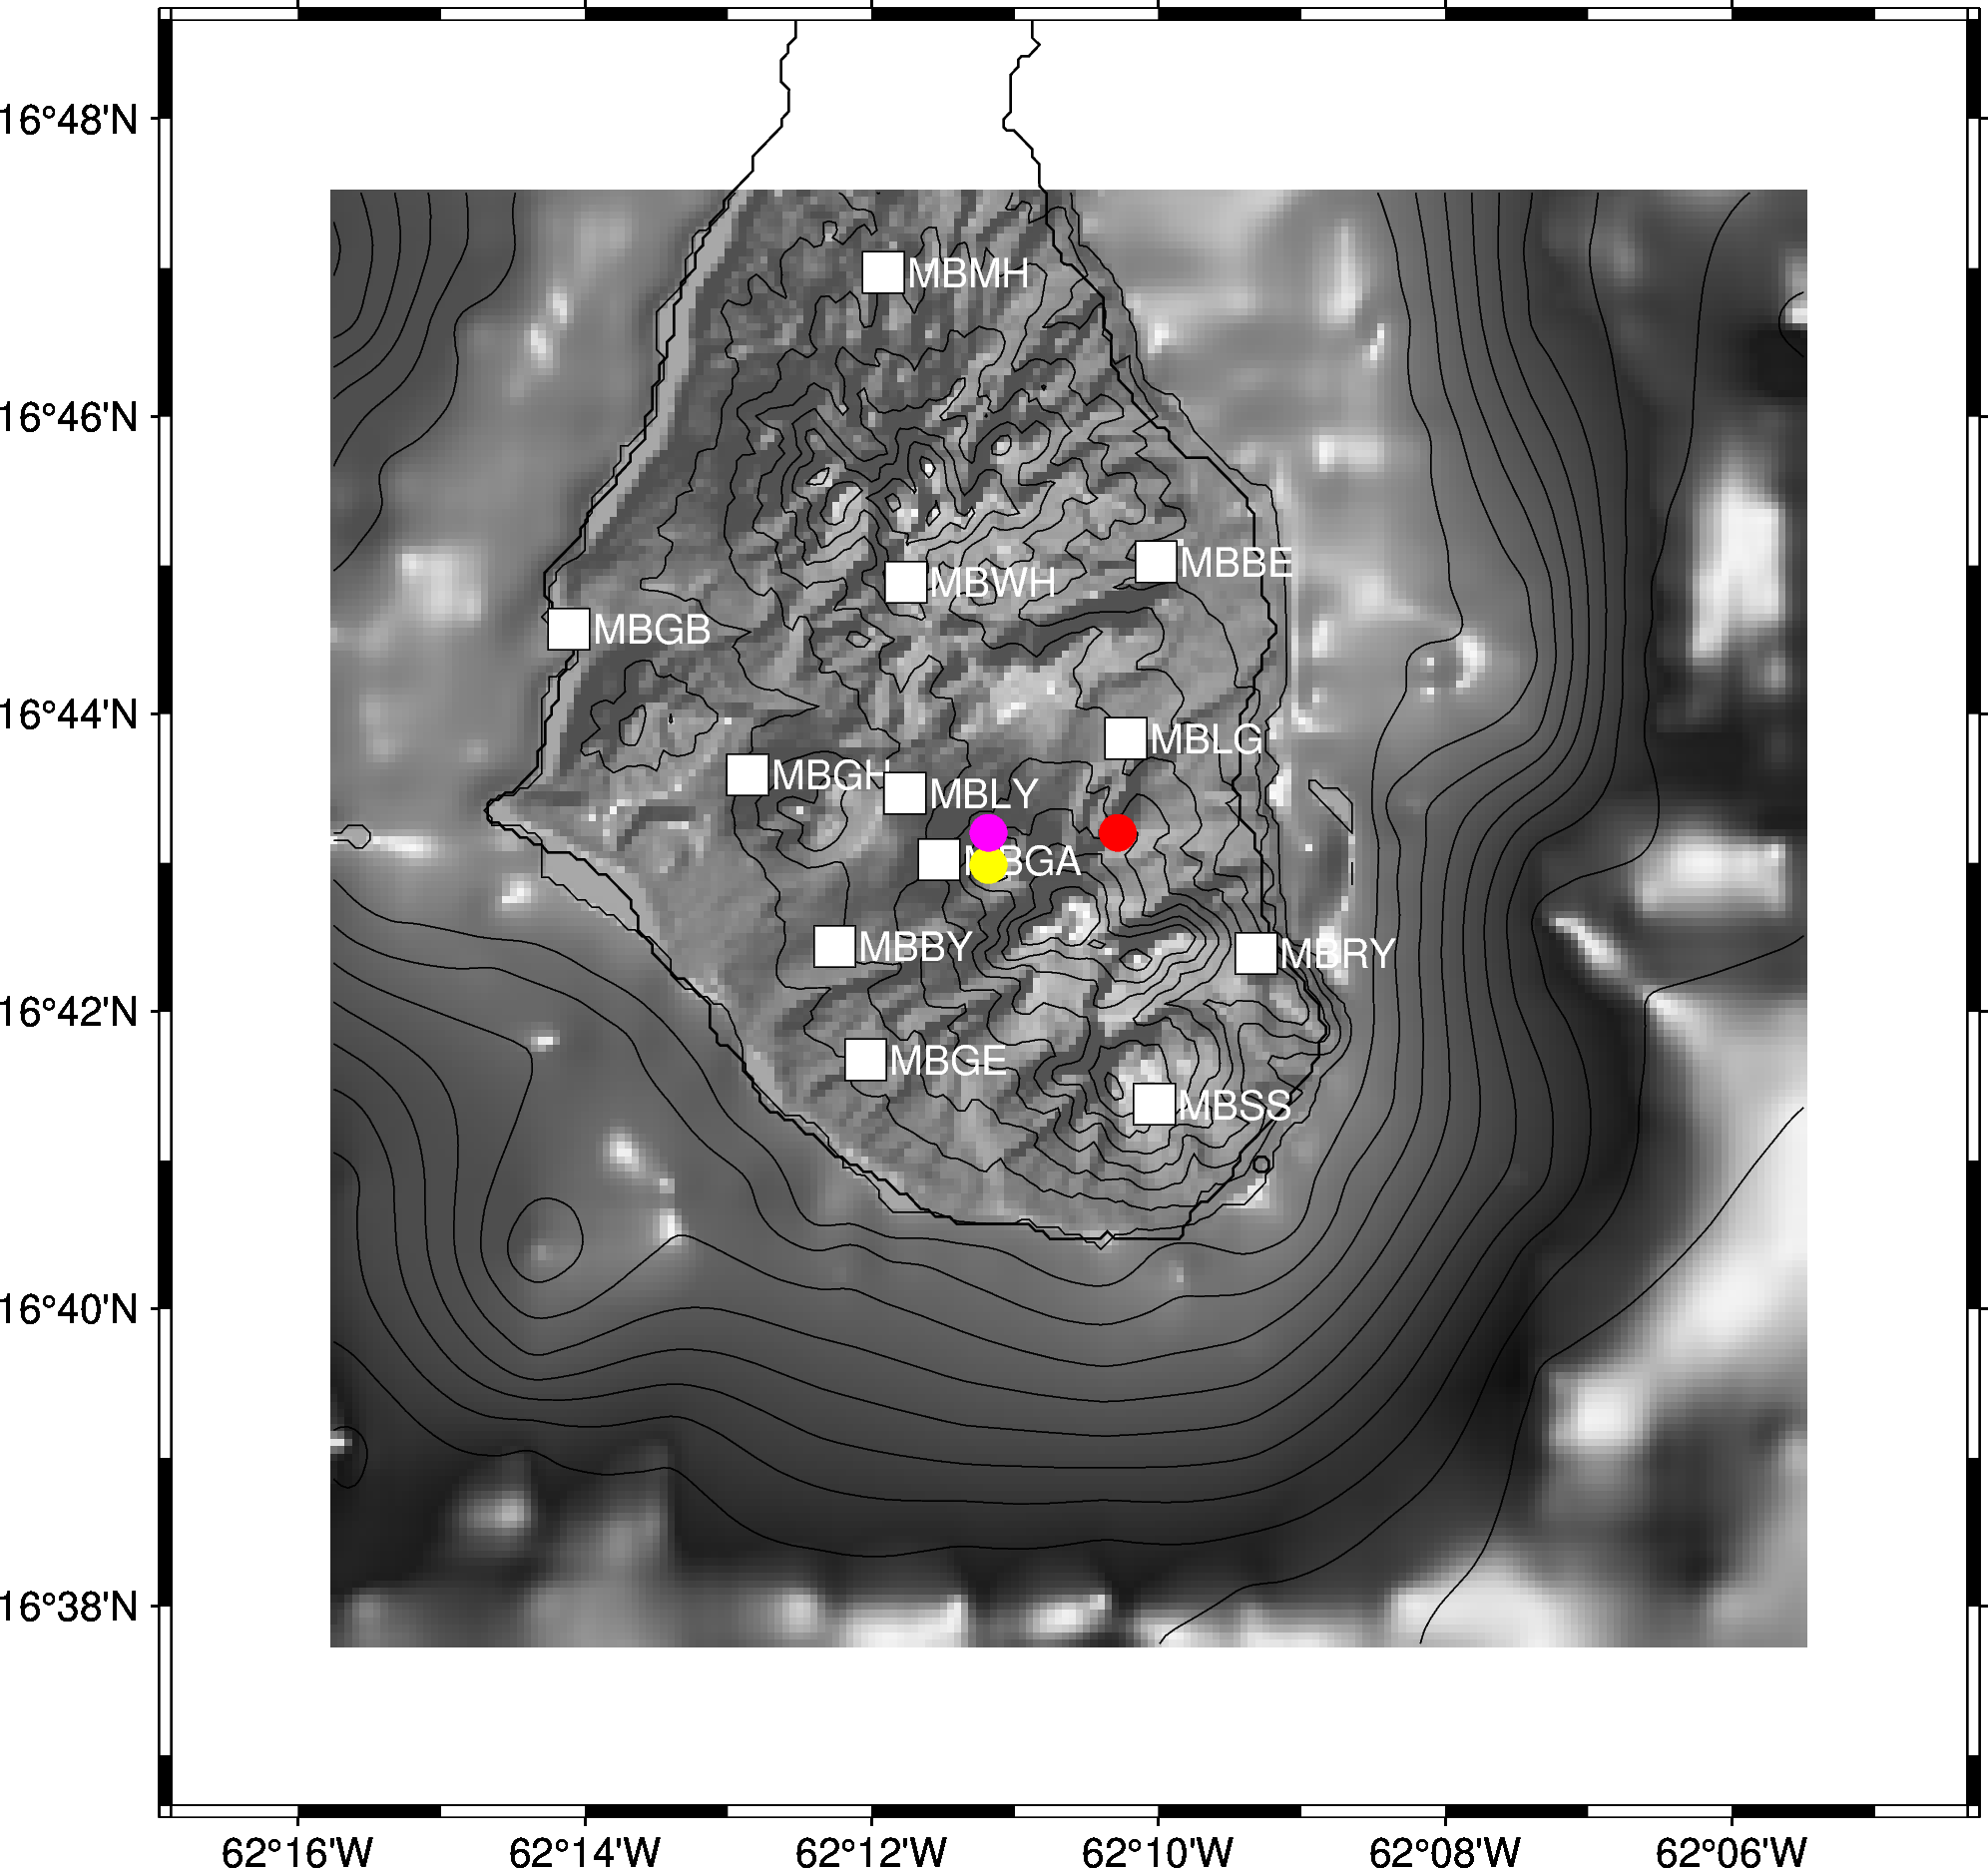

(<pygmt.figure.Figure at 0x15a2430b0>, array([41, 53, 49]))

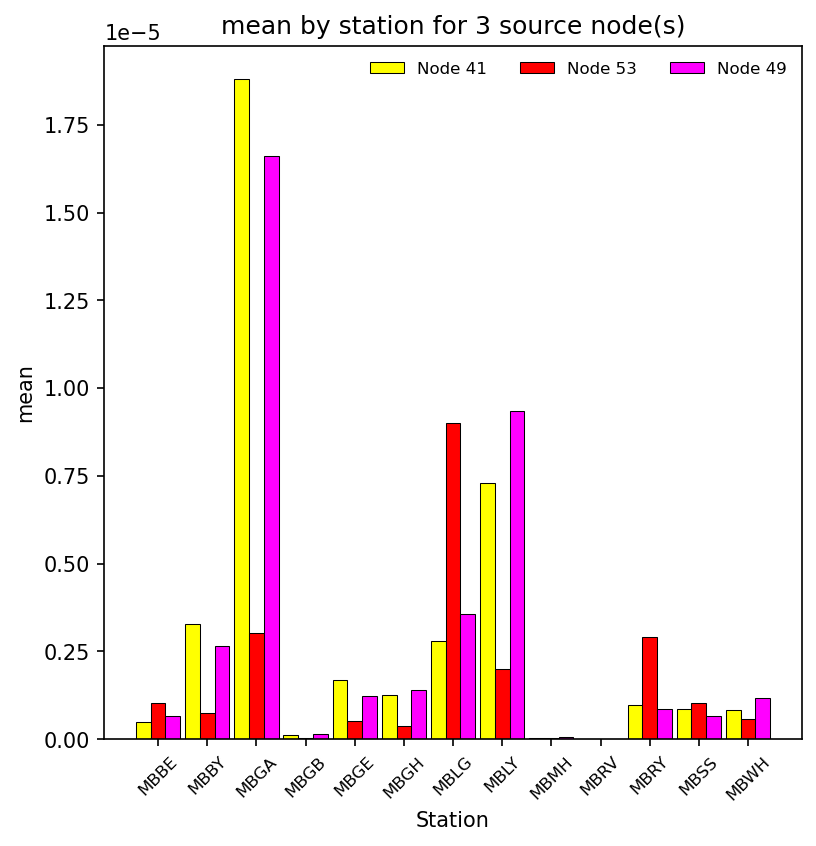

In [4]:
print(synthVSAMobj.get_seed_ids()  )
plot_SAM(synthVSAMobj, gridobj, K=3, metric='mean', DEM_DIR=DEM_DIR, inv=invMVO)

### 2.3 Plot synthetic source locations, and DR time series (all equal=100 ${cm}^2$)

topo_map: region=[np.float64(-62.23654683939817), np.float64(-62.14374452047298), np.float64(16.653965053072692), np.float64(16.74285394196158)]


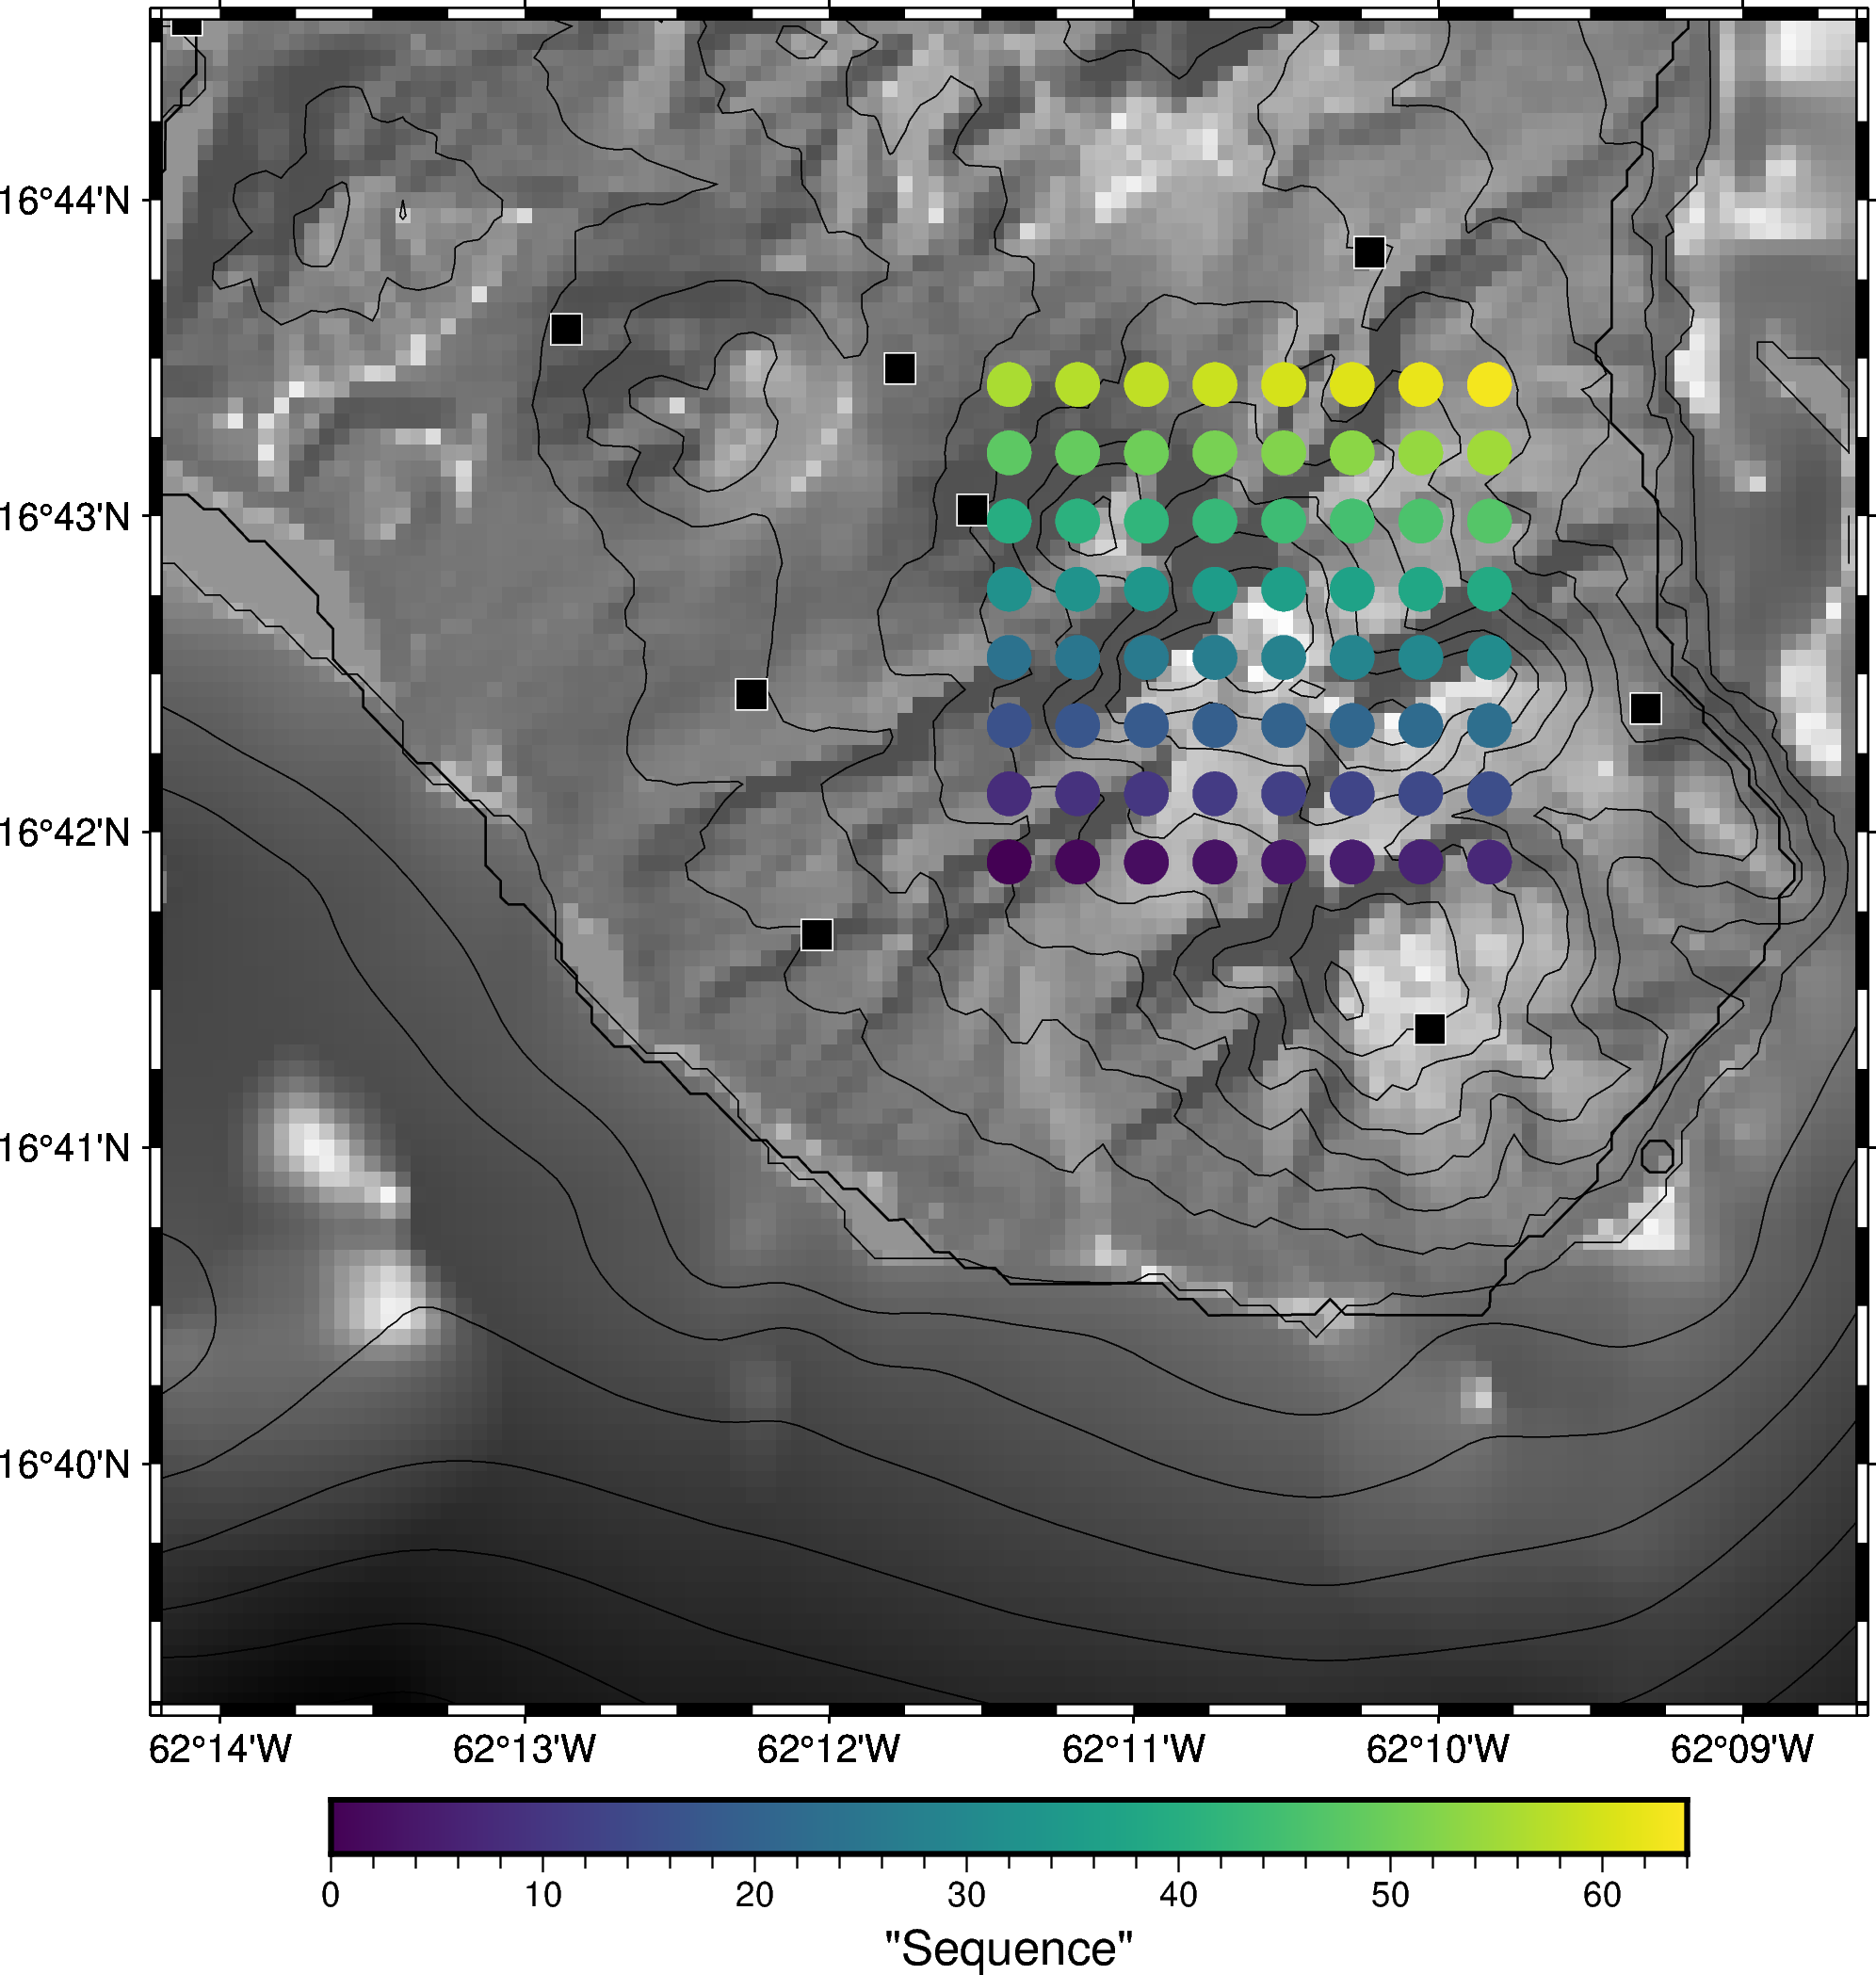

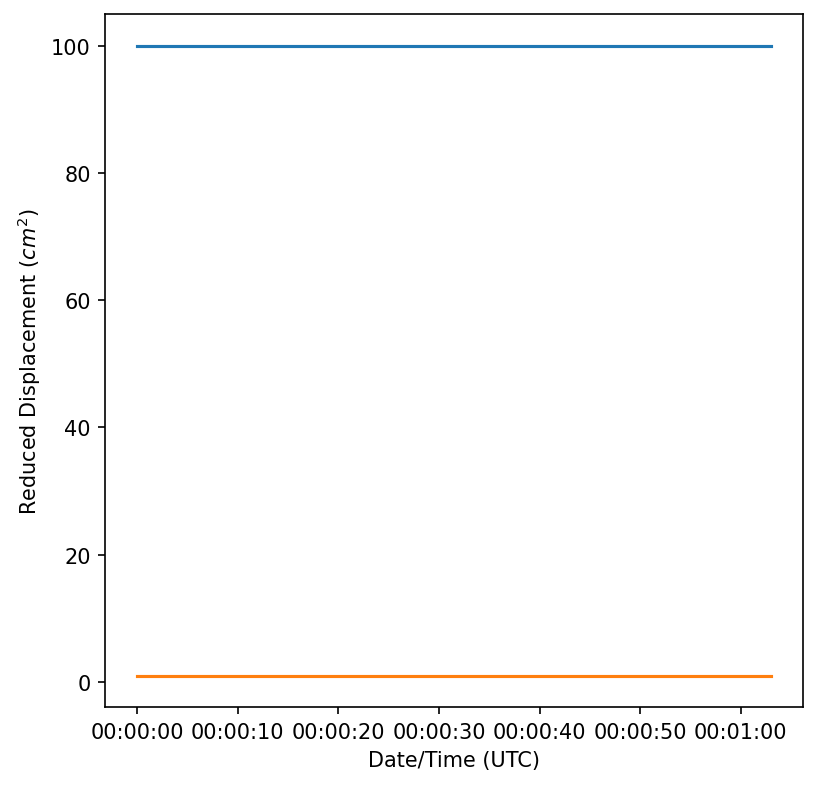

In [5]:
window_seconds = 1
aslobj = ASL(synthVSAMobj, 'mean', invMVO, gridobj, window_seconds)
aslobj.source = synthetic_source
aslobj.plot(zoom_level=2, threshold_DR=1.0, scale=0.4)

### 2.4 Run slow location algorithm on synthetic source and plot resulting locations and DR time series

[INFO] Computing distances using 13 channels from inventory.
[DONE] Grid distances computed for 13 trace IDs.
[INFO] Creating amplitude corrections for all inventory channels (Q=23, f=8.0)
[CACHE SAVE] Amplitude corrections saved to asl_cache/ampcorr_Q23_V2_f8_surf.pkl
Location algorithm took 0.10353994369506836 s
topo_map: region=[np.float64(-62.210259851903814), np.float64(-62.11744878822503), np.float64(16.671951485191066), np.float64(16.760840374079955)]


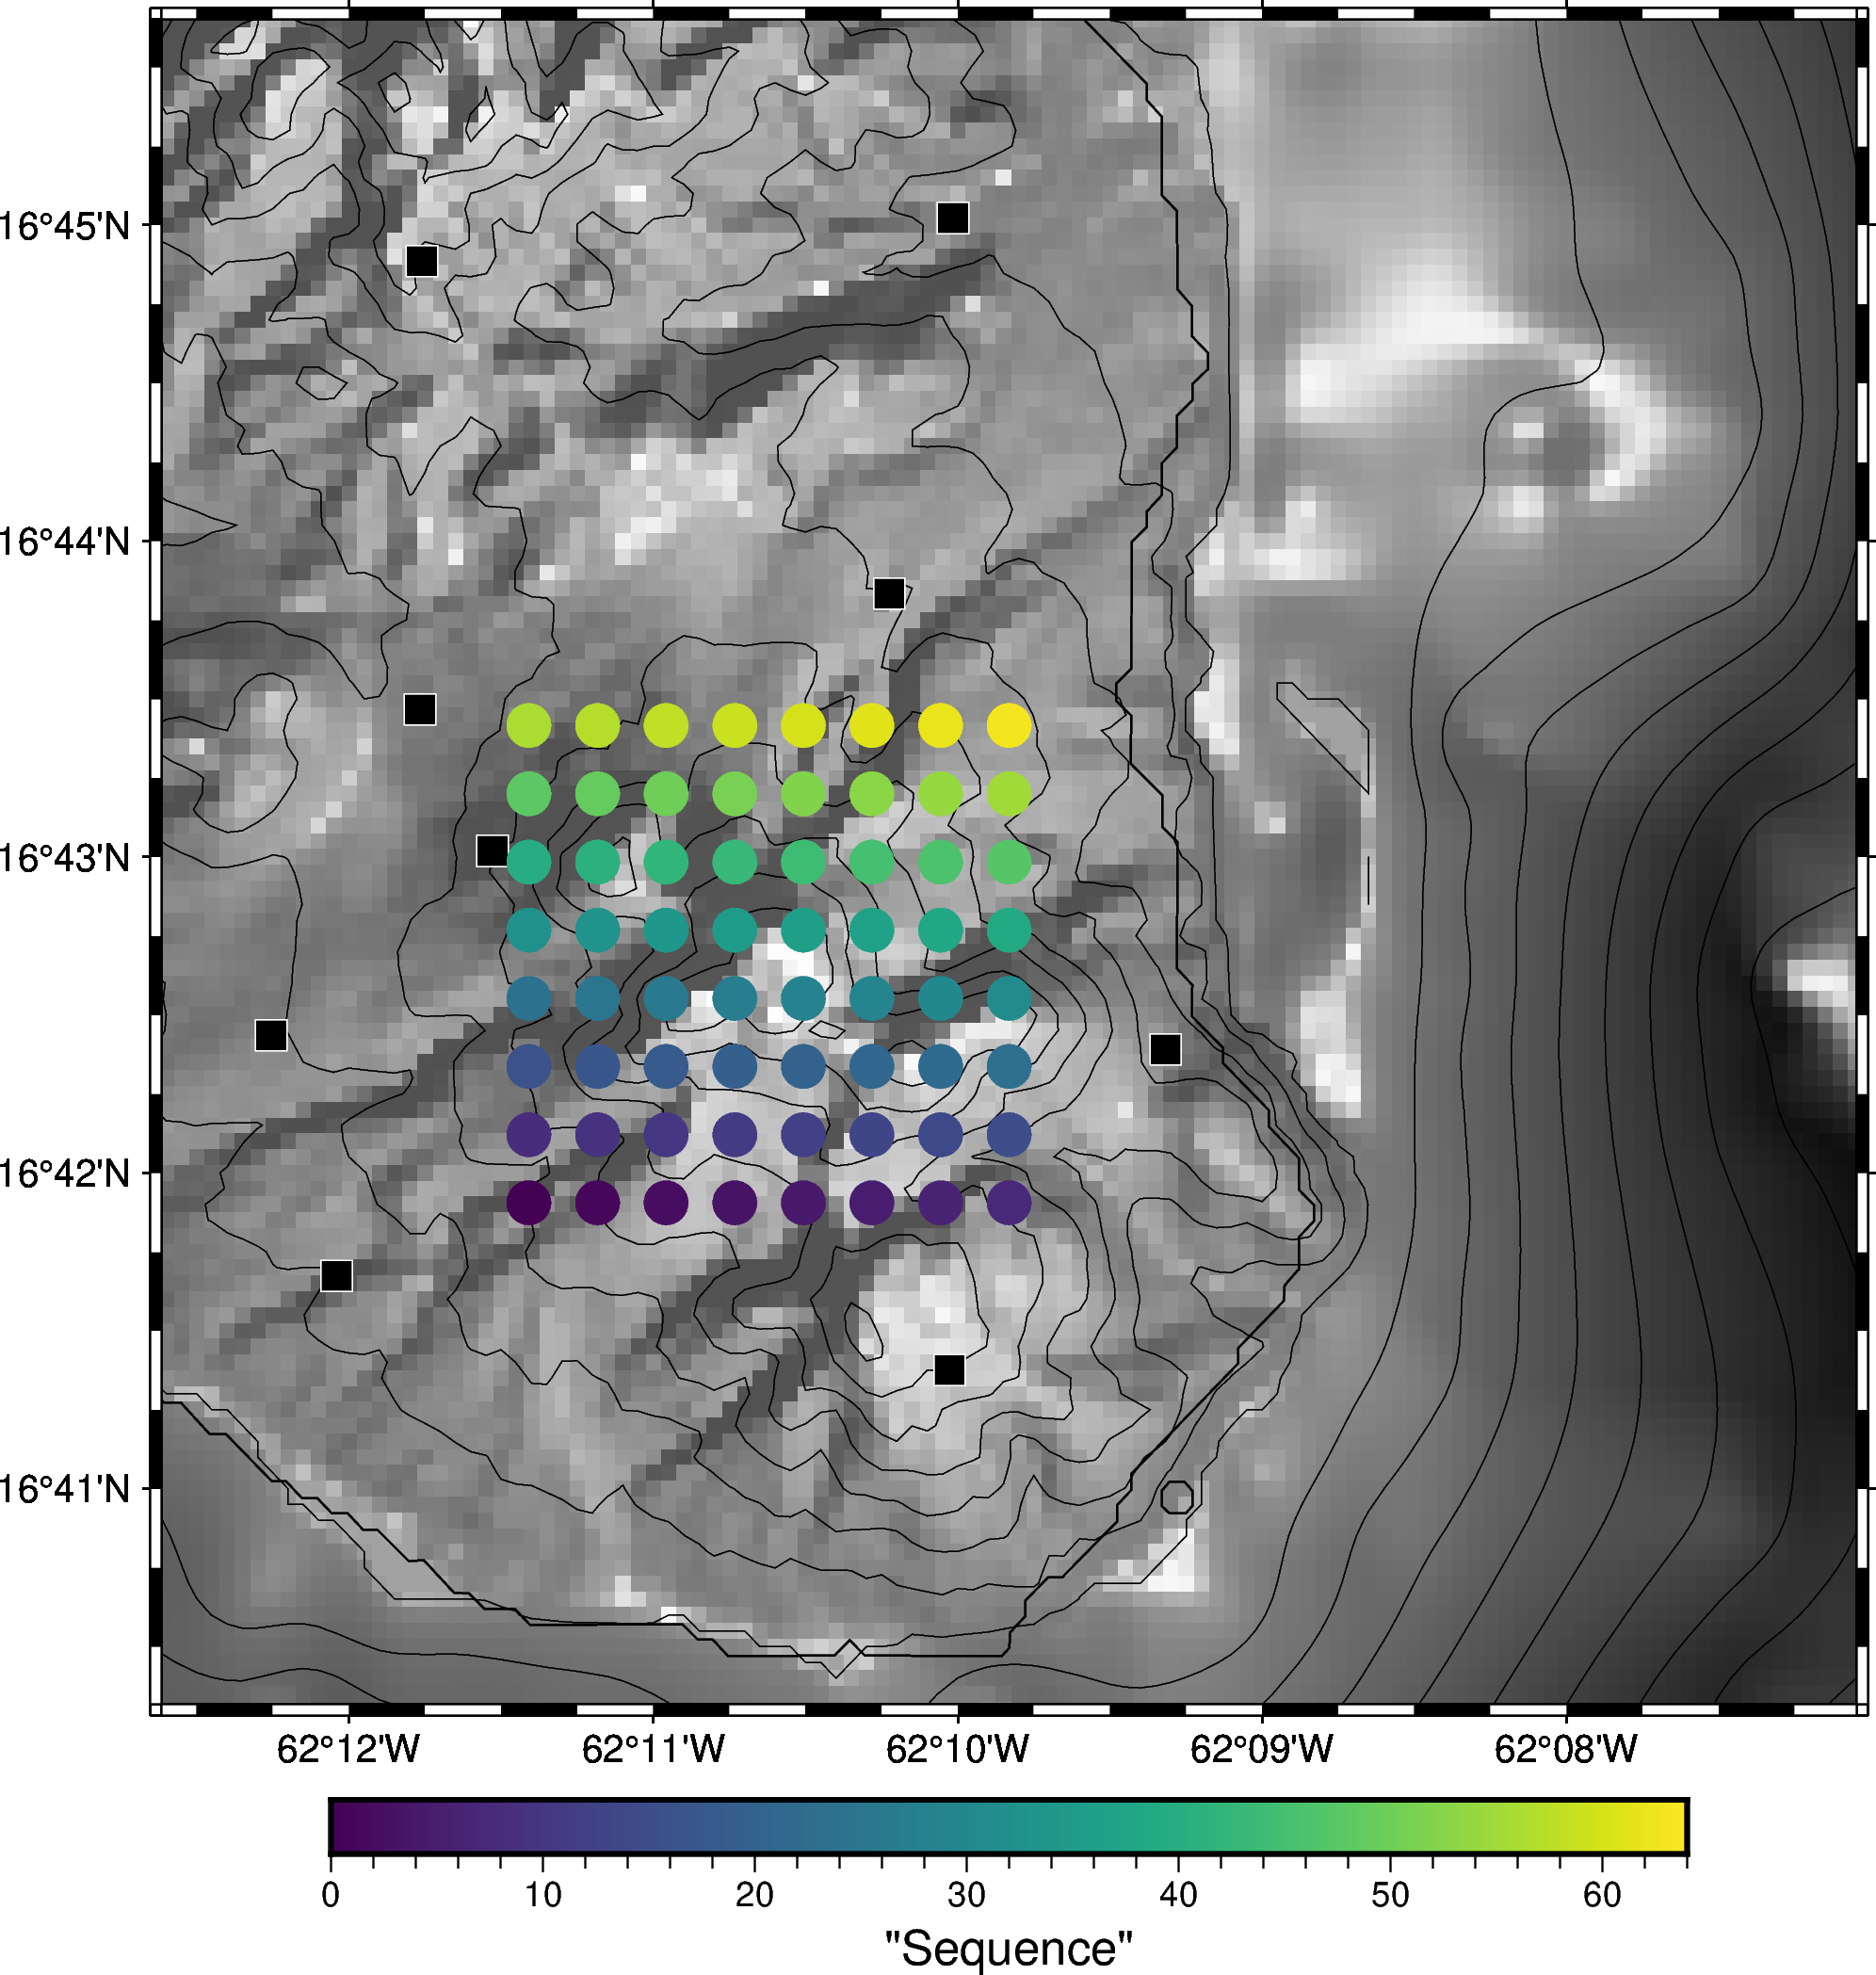

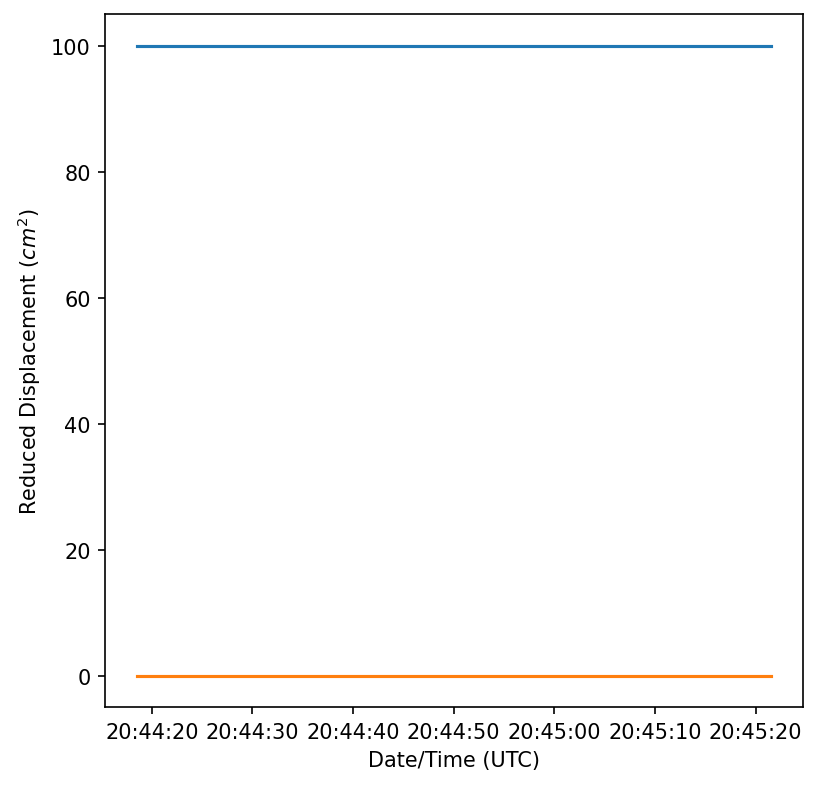

In [6]:
import time
aslobj.compute_grid_distances()
aslobj.compute_amplitude_corrections(surfaceWaves=True, wavespeed_kms=surfaceWaveSpeed_kms, Q=Q, fix_peakf=peakf, force_recompute=True)
time1 = time.time()
aslobj.locate()
time2 = time.time()
print(f'Location algorithm took {time2-time1} s')
aslobj.plot(zoom_level=2, scale=0.4, threshold_DR=0.0)

### 2.5 Run fast location algorithm on synthetic source and plot resulting locations and DR time series

Vectorized location algorithm took 0.02007293701171875 s
topo_map: region=[np.float64(-62.210259851903814), np.float64(-62.11744878822503), np.float64(16.671951485191066), np.float64(16.760840374079955)]


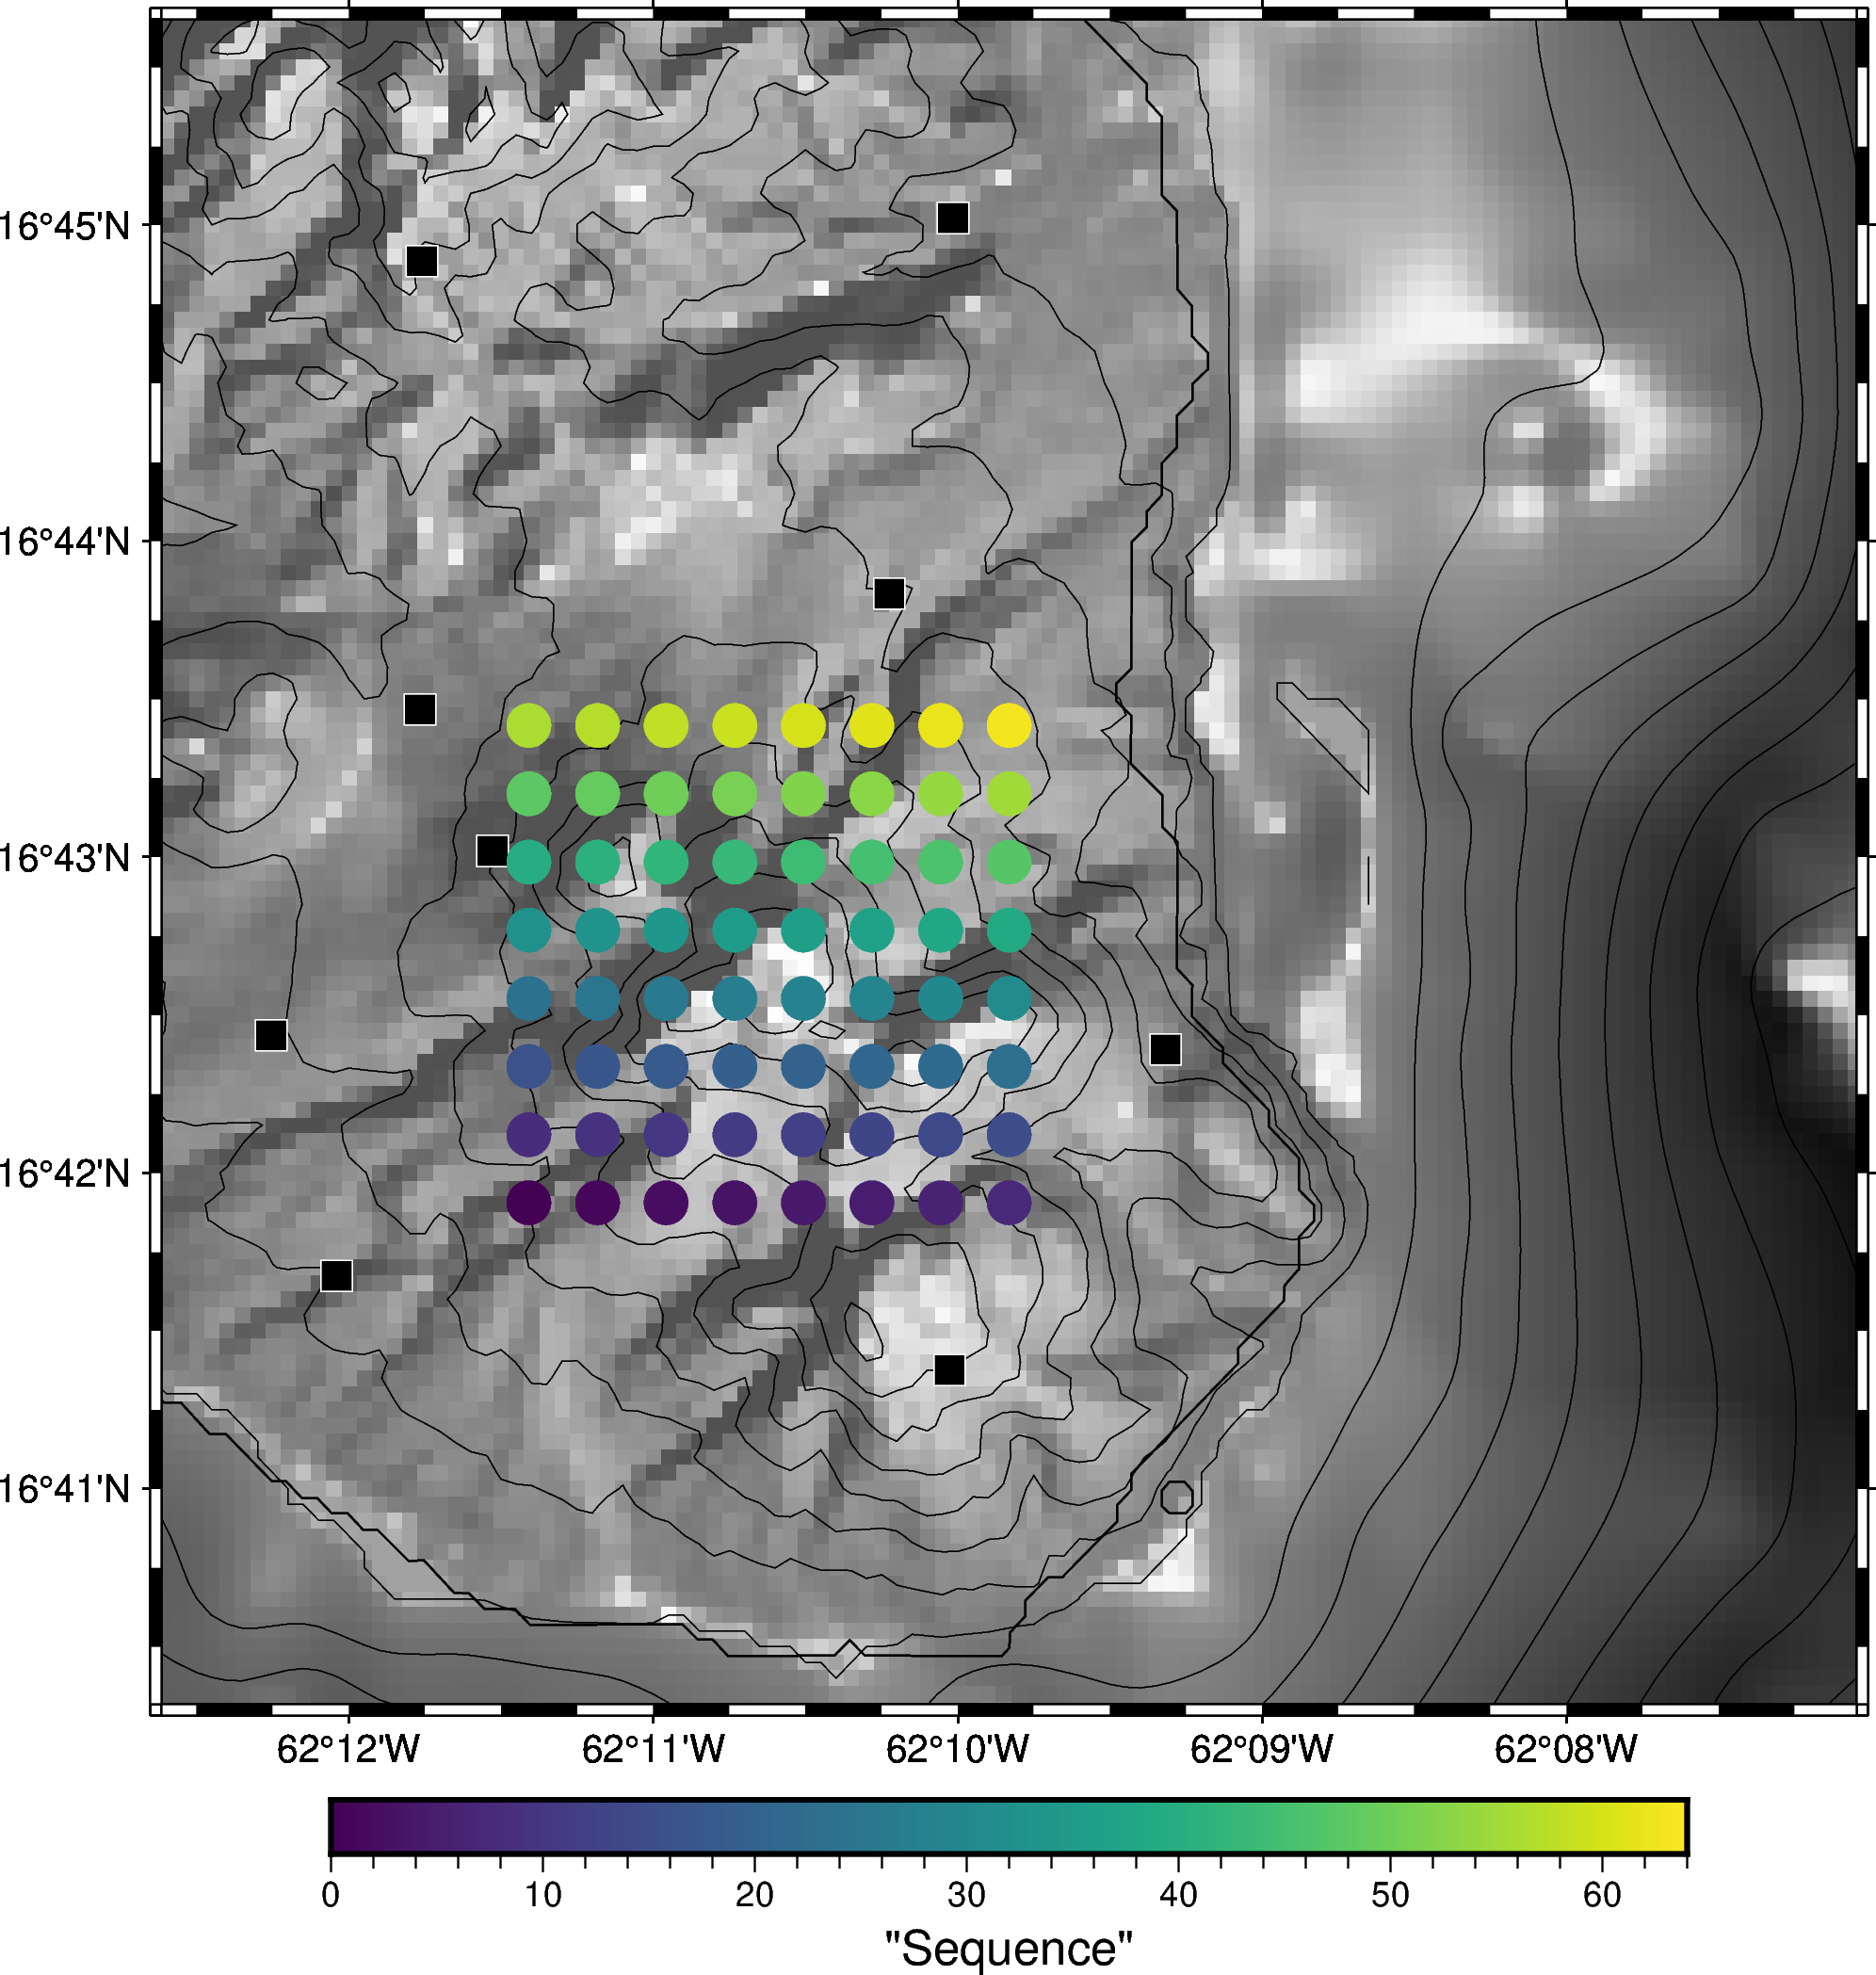

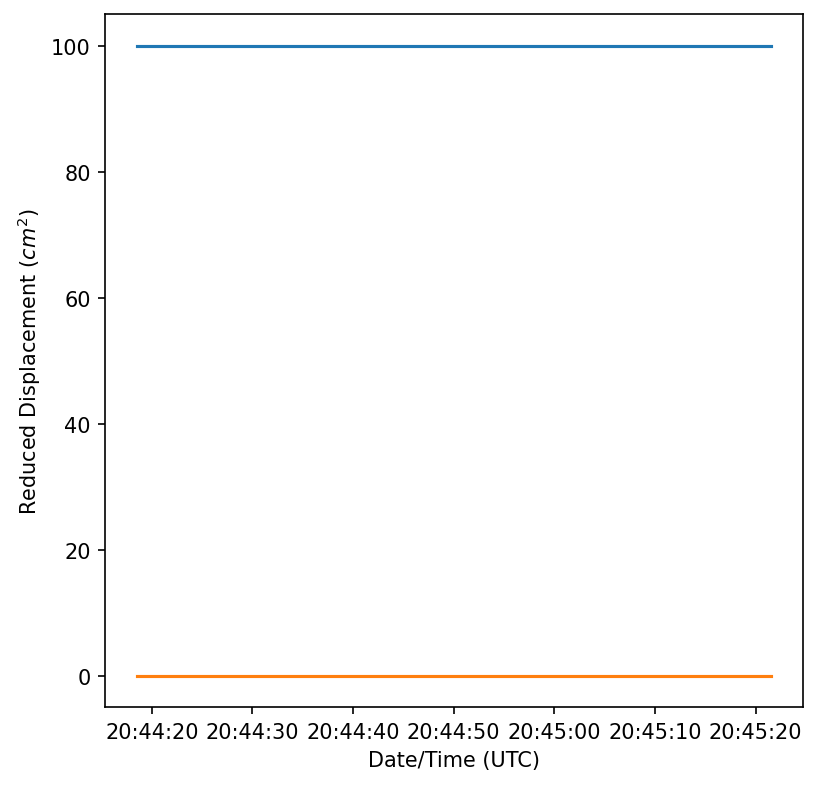

In [7]:
import copy
aslobj2 = copy.deepcopy(aslobj)
aslobj2.source = None
time1 = time.time()
aslobj2.fast_locate()
time2 = time.time()
print(f'Vectorized location algorithm took {time2-time1} s')
aslobj2.plot(zoom_level=2, scale=0.4, threshold_DR=0.0)

### 2.6 Compare results of (slow) locate and fast_locate


In [ ]:
result = compare_asl_sources(aslobj, aslobj2)

✅ ASL sources are identical.
                              t        lat        lon     DR        misfit  \
0   2025-09-13T20:44:18.528648Z  16.698409 -62.190146  100.0  7.963907e-14   
1   2025-09-13T20:44:19.528650Z  16.698409 -62.186390  100.0  1.415739e-13   
2   2025-09-13T20:44:20.528652Z  16.698409 -62.182634  100.0  1.164951e-13   
3   2025-09-13T20:44:21.528654Z  16.698409 -62.178878  100.0  1.427518e-13   
4   2025-09-13T20:44:22.528657Z  16.698409 -62.175122  100.0  8.930376e-14   
..                          ...        ...        ...    ...           ...   
59  2025-09-13T20:45:17.528775Z  16.723591 -62.178878  100.0  8.946016e-14   
60  2025-09-13T20:45:18.528777Z  16.723591 -62.175122  100.0  1.149845e-13   
61  2025-09-13T20:45:19.528779Z  16.723591 -62.171366  100.0  7.090252e-14   
62  2025-09-13T20:45:20.528781Z  16.723591 -62.167610  100.0  1.249336e-13   
63  2025-09-13T20:45:21.528783Z  16.723591 -62.163854  100.0  1.086099e-13   

         azgap  nsta  
0   137.512

## 3 Locating real DSAM data: July 12, 2003 collapse

Now we are confident in our ability to locate synthetic data correctly, and determine reduced displacement correctly, we will try to locate some real data. In this example, we use the 'VT' metric from the DSAM dataset. Recall that this is the mean amplitude of the signal (over 60-s time windows) after filtering between 4 and 18 Hz, rather than the 'mean' metric (or 'median', or 'rms' etc.) which are computed on signals filtered between 0.5 and 18 Hz. We do this because Jolly et al. (2002) determined that a 7-9 Hz bandpass was best for locating pyroclastic flows, and so the VT band is the one we have available that best matches this.

### 3.1 Read inventory and DSAM data. Plot DSAM data

Reading /Volumes/PulwtopHome/Dropbox/BRIEFCASE/SSADenver/test_mess2024/data/continuous/SAM/DSAM/MV/DSAM_MV.MBGH..BHZ_2003_60s.pickle
Reading /Volumes/PulwtopHome/Dropbox/BRIEFCASE/SSADenver/test_mess2024/data/continuous/SAM/DSAM/MV/DSAM_MV.MBLG..SHZ_2003_60s.pickle
Reading /Volumes/PulwtopHome/Dropbox/BRIEFCASE/SSADenver/test_mess2024/data/continuous/SAM/DSAM/MV/DSAM_MV.MBRY..BHZ_2003_60s.pickle
Reading /Volumes/PulwtopHome/Dropbox/BRIEFCASE/SSADenver/test_mess2024/data/continuous/SAM/DSAM/MV/DSAM_MV.MBSS..SHZ_2003_60s.pickle
Reading /Volumes/PulwtopHome/Dropbox/BRIEFCASE/SSADenver/test_mess2024/data/continuous/SAM/DSAM/MV/DSAM_MV.MBWH..SHZ_2003_60s.pickle
METRIC: VT


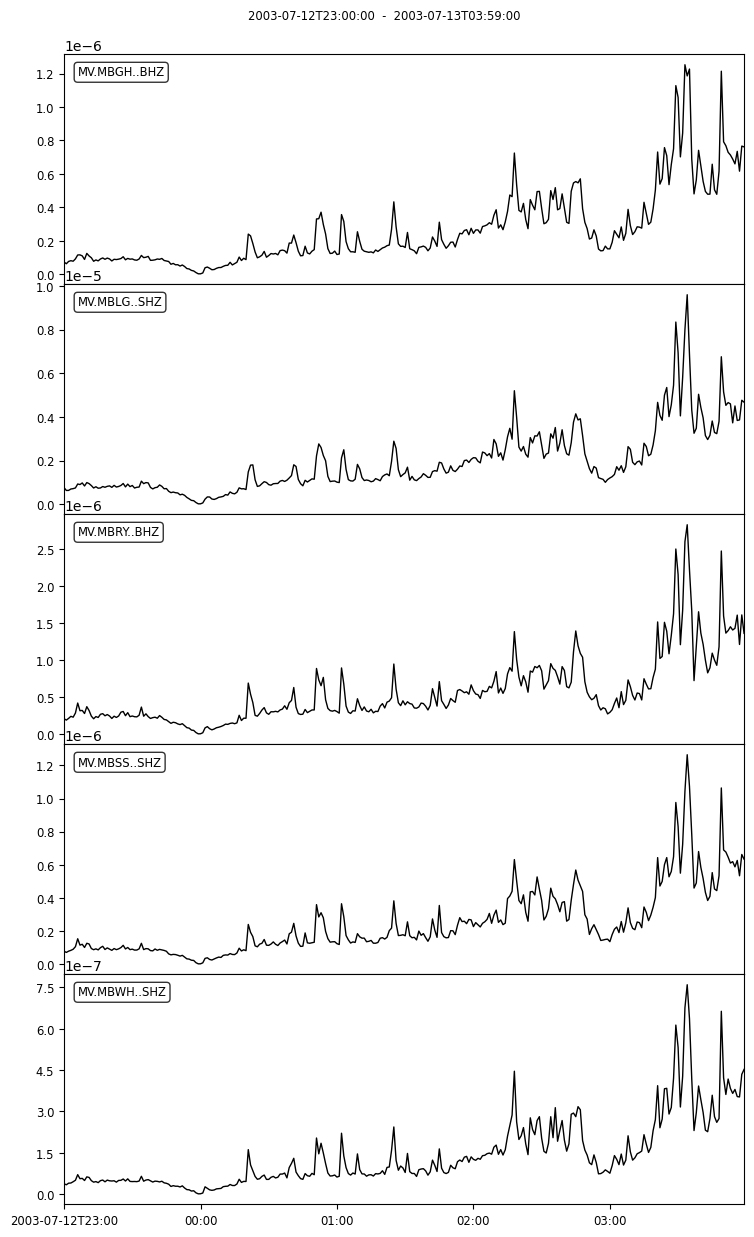

In [9]:
from flovopy.stationmetadata.utils import subset_inv 
startt = obspy.UTCDateTime(2003,7,12,23,0,0)
endt = obspy.UTCDateTime(2003,7,13,4,0,0)
dsamObj = DSAM.read(startt, endt, SAM_DIR=SAM_DIR, sampling_interval=60, ext='pickle', \
                     trace_ids=['MV.MBGH..BHZ', 'MV.MBLG..SHZ', 'MV.MBRY..BHZ', 'MV.MBSS..SHZ', 'MV.MBWH..SHZ'], verbose=True)  
inv_subset = subset_inv(invMVO, dsamObj.to_stream(), level="channel")
dsamObj.plot(metrics='VT')

### 3.2 Create dense grid (20-m node spacing) and plot

topo_map: region=[np.float64(-62.22340665192458), np.float64(-62.13059334807542), 16.676555555555556, 16.765444444444444]


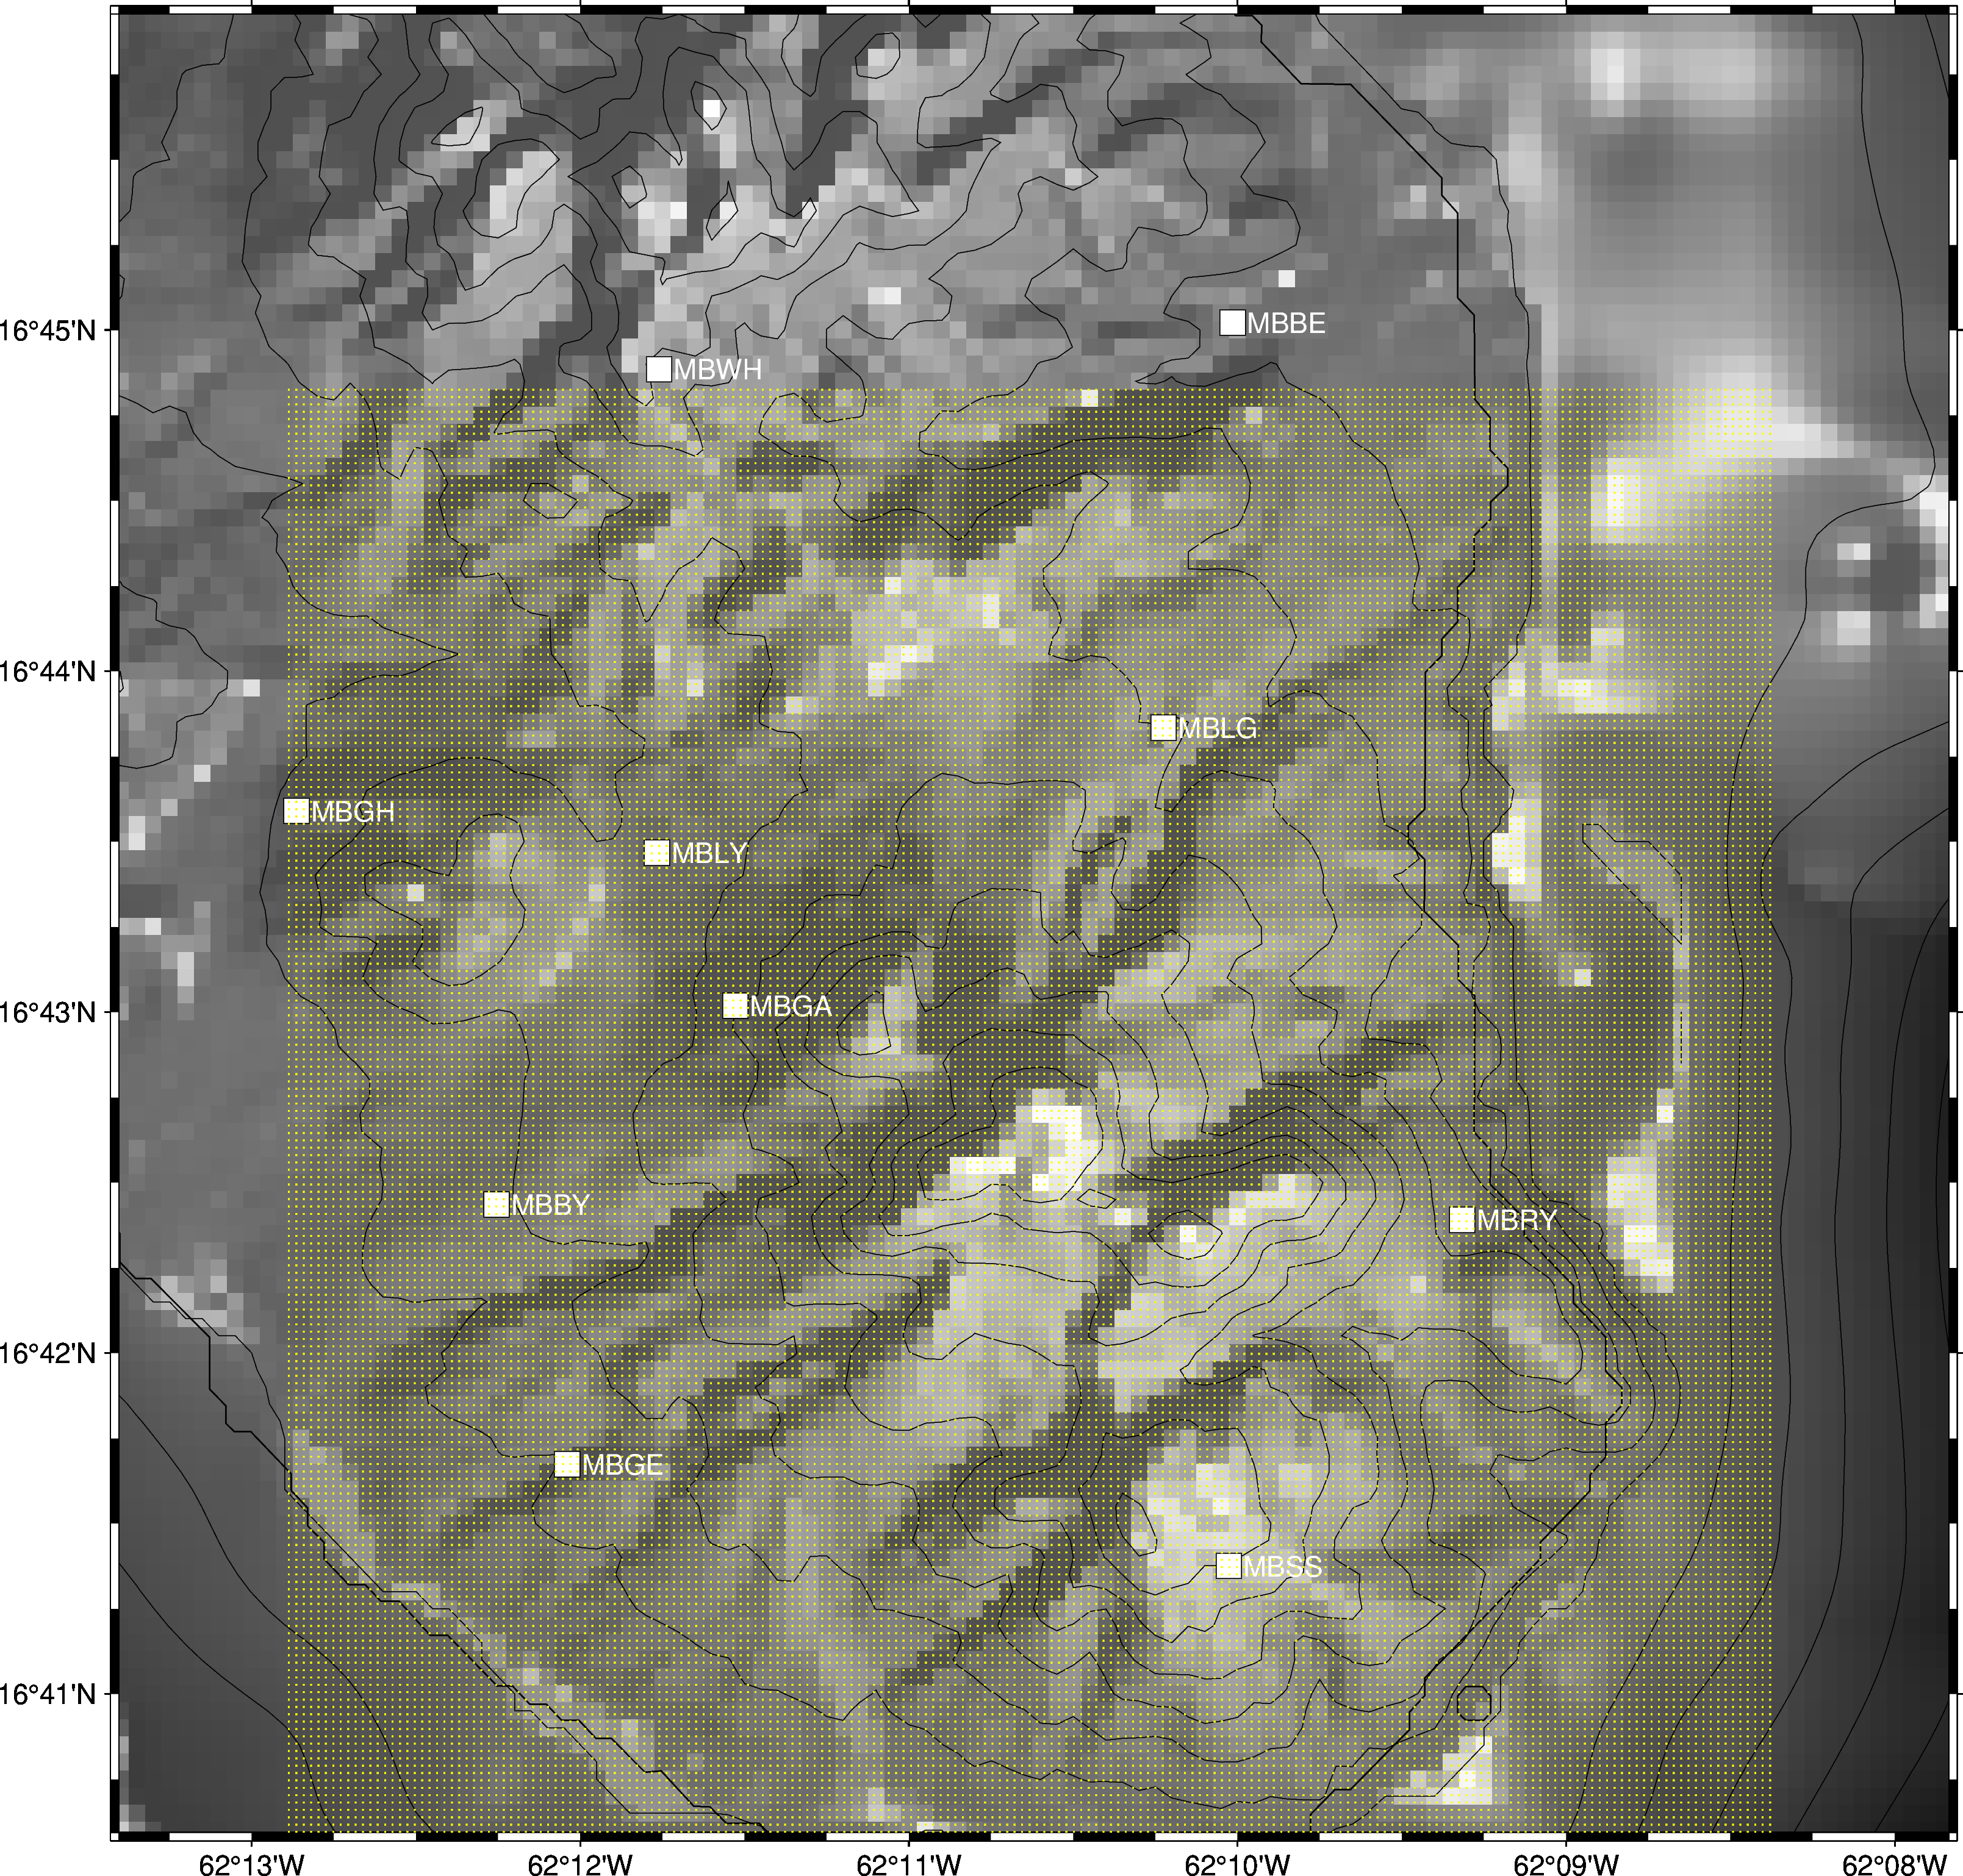

In [10]:
source = {'lat':16.71111, 'lon':-62.17722}
node_spacing_m = 40
grid_size_lat_m = 8000
grid_size_lon_m = 8000
nlat = int(grid_size_lat_m/node_spacing_m) + 1
nlon = int(grid_size_lon_m/node_spacing_m) + 1
gridobj = Grid(source['lat'], source['lon'], nlat, nlon, node_spacing_m)  
topo_map_args = {'inv':invMVO, 'DEM_DIR':DEM_DIR, 'add_labels':True, 'zoom_level':2, 'topo_color':False, 'figsize':10}
gridobj.plot(scale=1.0, symbol='s', pen="0.25p,yellow", topo_map_kwargs=topo_map_args);

### 3.3 Create ASL object, compute combined geometrical spreading and inelatic attenuation corrections for each node

In [11]:
Q = 23
surfaceWaveSpeed_kms = 1.5 # km/s
peakf = 8.0
aslobj3 = ASL(dsamObj, 'rms', invMVO, gridobj, window_seconds=60)
aslobj3.compute_grid_distances()
aslobj3.compute_amplitude_corrections(surfaceWaves=True, wavespeed_kms=surfaceWaveSpeed_kms, Q=Q, fix_peakf = peakf, force_recompute=True)

[INFO] Computing distances using 13 channels from inventory.
[DONE] Grid distances computed for 13 trace IDs.
[INFO] Creating amplitude corrections for all inventory channels (Q=23, f=8.0)
[CACHE SAVE] Amplitude corrections saved to asl_cache/ampcorr_Q23_V2_f8_surf.pkl


### 3.4 Run the amplitude location

In [12]:
aslobj3.fast_locate()

### 3.5 Plot sources and source reduced displacements

topo_map: region=[np.float64(-62.21003516943391), np.float64(-62.148160741283974), np.float64(16.68795548593299), np.float64(16.747214745192245)]


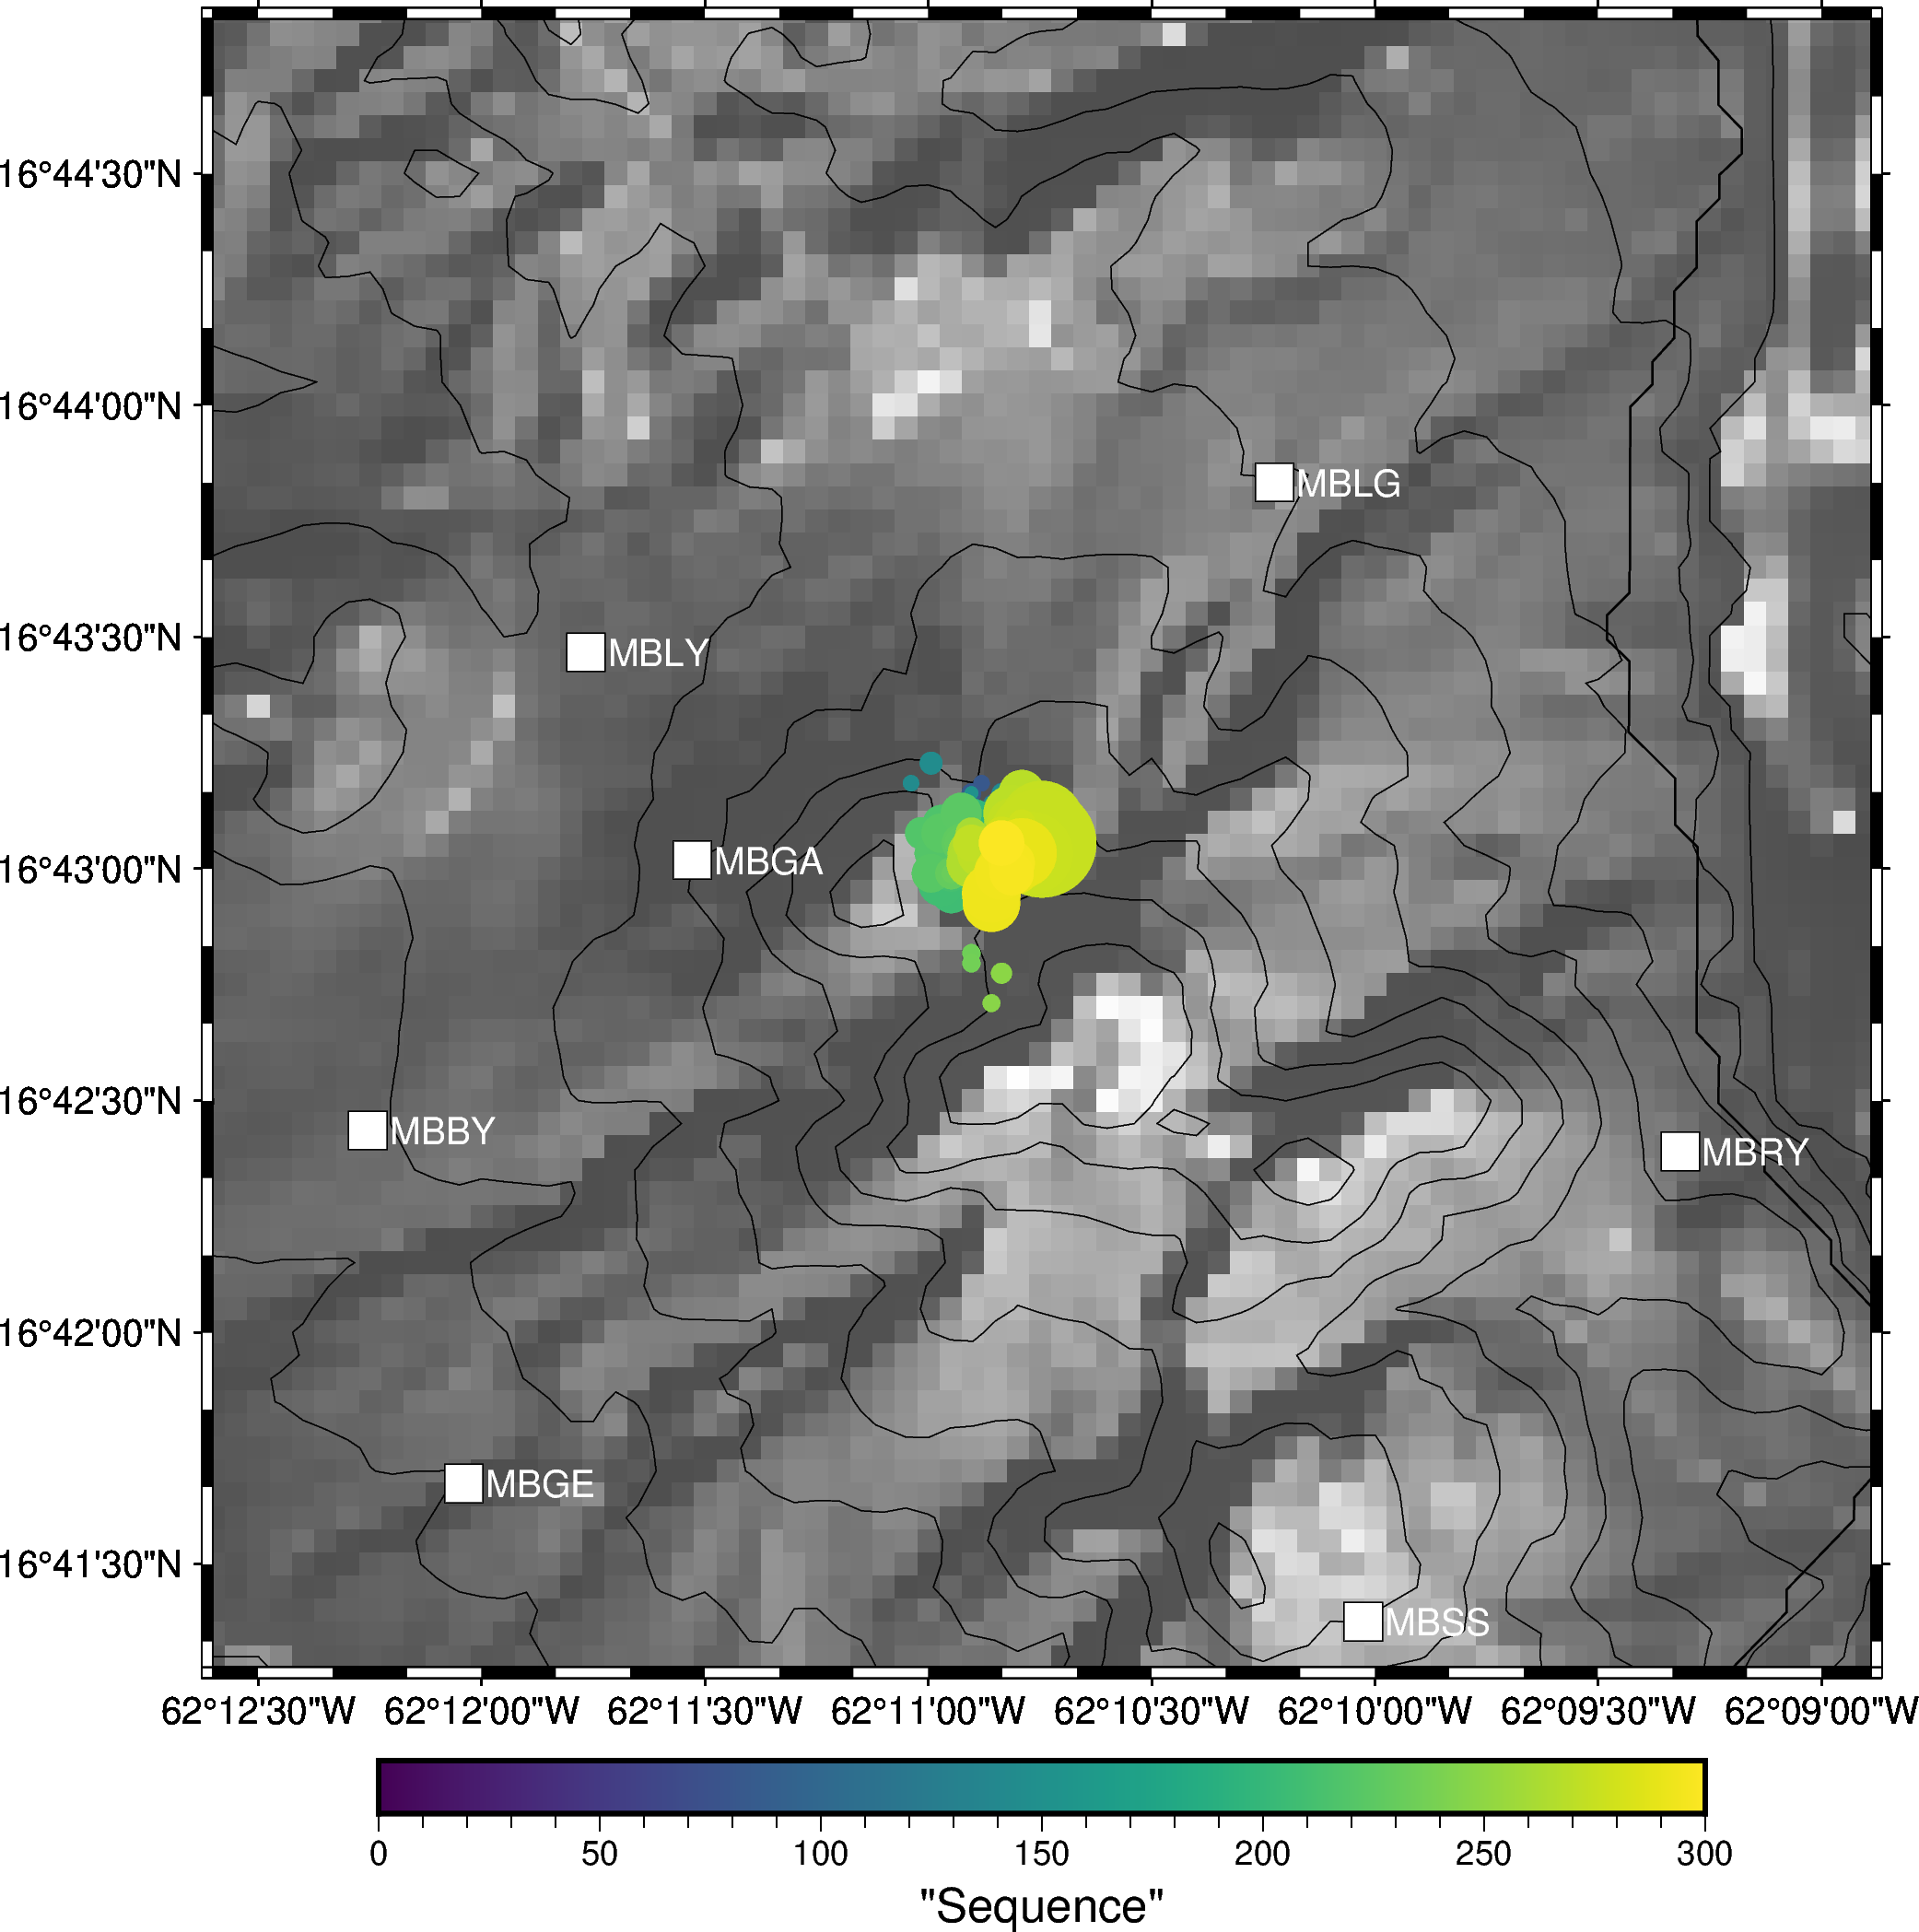

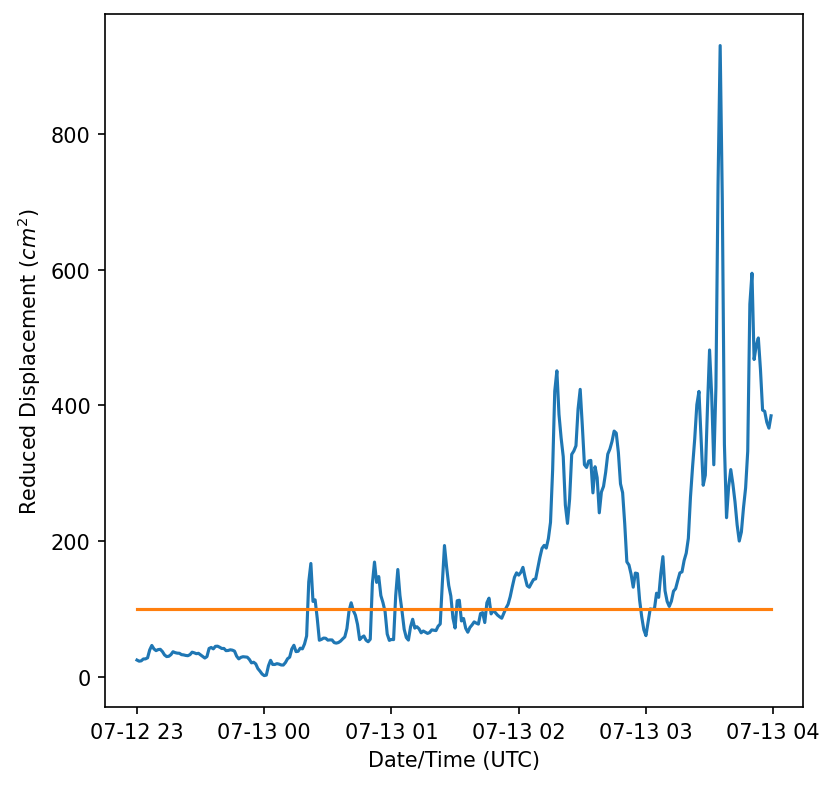

In [13]:
aslobj3.plot(zoom_level=3, threshold_DR=100.0, scale=1, add_labels=True)

## 3.6 Now based on where this is signal located, let's try to see if average amplitude ratios matched those from models assuming this location


Location with the strongest signal: lat=16.717585115562617, lon=-62.17909795535894, DR=930.6892891505864


([0, 1, 2, 3, 4],
 [Text(0, 0, 'MBGH'),
  Text(1, 0, 'MBLG'),
  Text(2, 0, 'MBRY'),
  Text(3, 0, 'MBSS'),
  Text(4, 0, 'MBWH')])

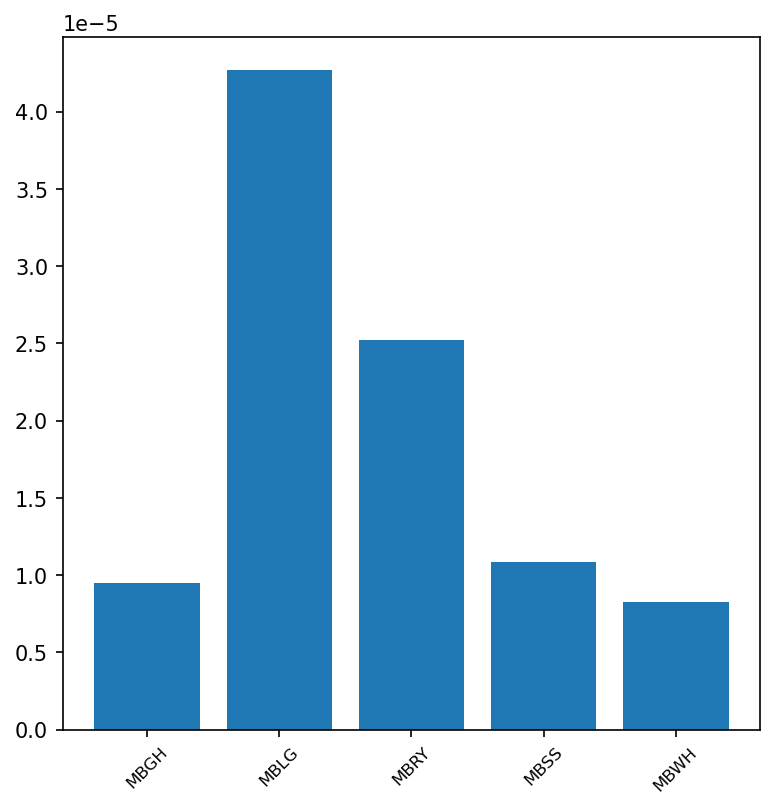

In [14]:
DR = max(aslobj3.source['DR'])
maxi = np.argmax(aslobj3.source['DR'])
slon = aslobj3.source['lon'][maxi]
slat = aslobj3.source['lat'][maxi]
print(f'Location with the strongest signal: lat={slat}, lon={slon}, DR={DR}')

# plot actual amplitude ratios
st = dsamObj.to_stream()
real_amplitudes = [tr.data[maxi] for tr in st ]
x = [id.split('.')[1] for id in dsamObj.get_seed_ids()]
plt.figure()
plt.bar(x, real_amplitudes, width=0.8)
plt.xticks(rotation=45, fontsize=8)

Inventory created at 2025-09-13T20:44:23.258407Z
	Created by: ObsPy 1.4.2
		    https://www.obspy.org
	Sending institution: ObsPy's obspy.io.xseed version 1.2.2
	Contains:
		Networks (5):
			MV (5x)
		Stations (5):
			MV.MBGH ()
			MV.MBLG ()
			MV.MBRY ()
			MV.MBSS ()
			MV.MBWH ()
		Channels (5):
			MV.MBGH..BHZ, MV.MBLG..SHZ, MV.MBRY..BHZ, MV.MBSS..SHZ, 
			MV.MBWH..SHZ
topo_map: region=[np.float64(-62.28140949400923), np.float64(-62.07259050599077), 16.610999999999997, 16.811]


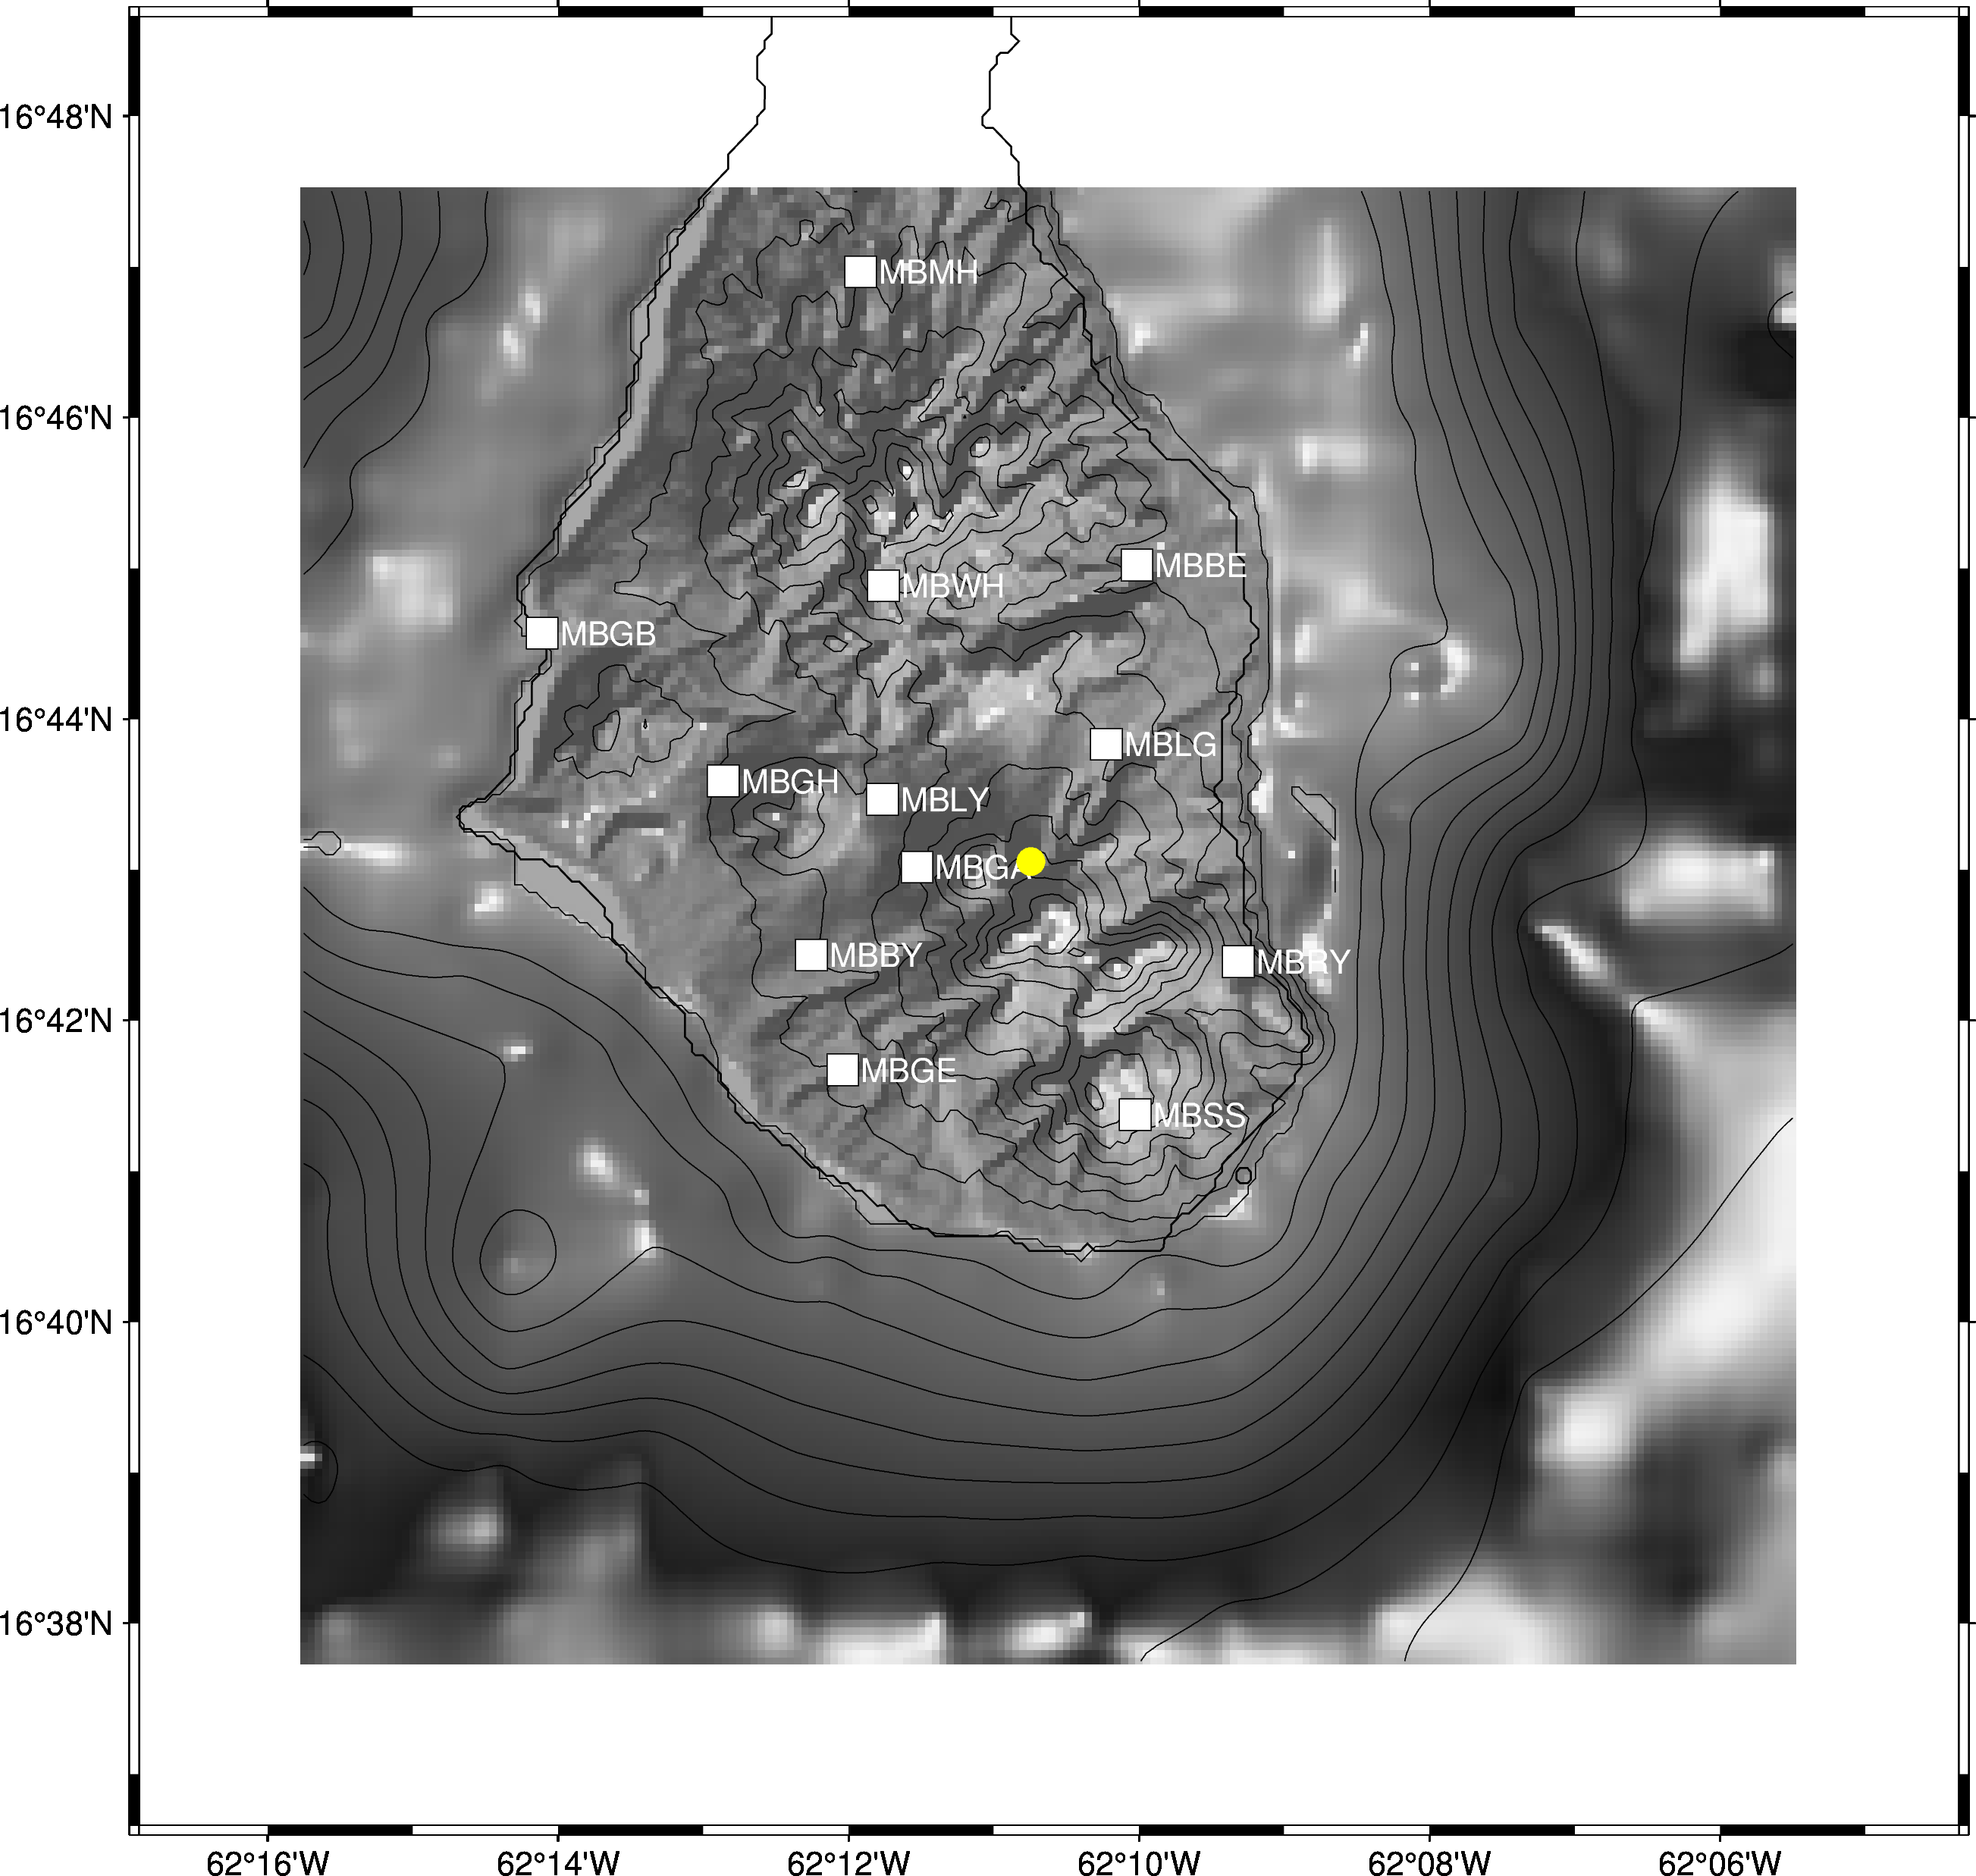

(<pygmt.figure.Figure at 0x158e883e0>, array([0]))

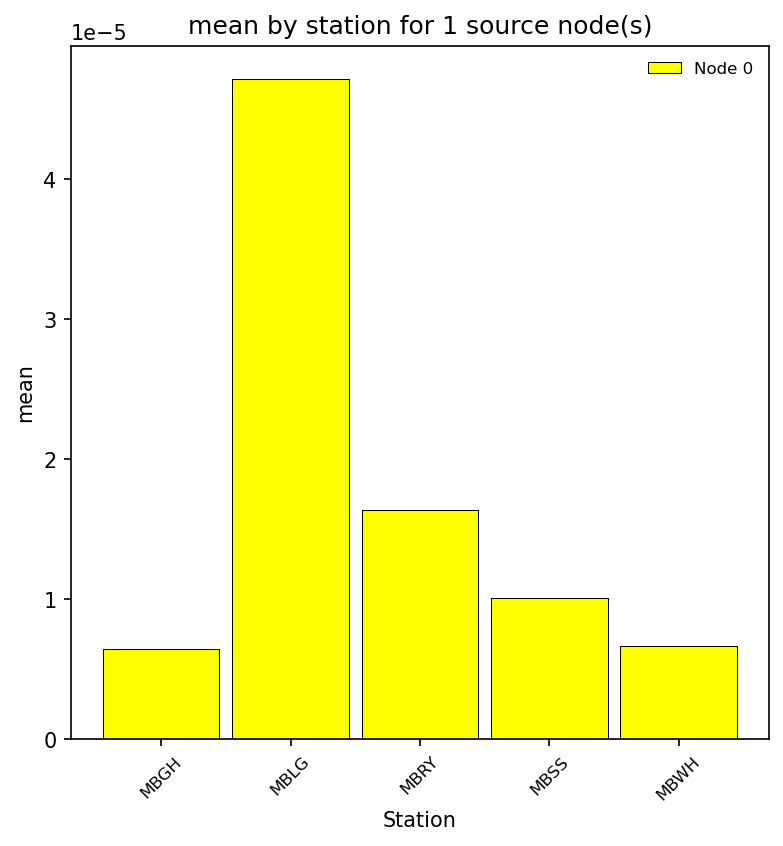

In [15]:
sampling_interval = 60.0  # seconds, to simulate moving window
gridobj = Grid(slat, slon, 1, 1, 1)

synthetic_source2 = synthetic_source_from_grid(
    gridobj,
    sampling_interval=sampling_interval,
    DR_cm2=DR,
    t0=obspy.UTCDateTime(0),
    order="C",
)

surfaceWaveSpeed_kms = 1.5
peakf = 8.0
Q = 23

print(inv_subset)
synthDSAMobj = simulate_SAM(
    inv_subset,
    synthetic_source2,
    surfaceWaves=True,
    wavespeed_kms=surfaceWaveSpeed_kms,
    peakf=peakf,
    Q=Q,
    noise_level_percent=0.0,
)
plot_SAM(synthDSAMobj, gridobj, K=1, metric='mean', DEM_DIR=DEM_DIR, inv=invMVO, figsize=8)


## 4. Locate a pyroclastic flow

Inventory created at 2024-01-11T03:20:26.394930Z
	Created by: ObsPy 1.4.0
		    https://www.obspy.org
	Sending institution: ObsPy's obspy.io.xseed version 1.2.2
	Contains:
		Networks (13):
			MV (13x)
		Stations (13):
			MV.MBBE ()
			MV.MBBY ()
			MV.MBGA ()
			MV.MBGB ()
			MV.MBGE ()
			MV.MBGH ()
			MV.MBLG ()
			MV.MBLY ()
			MV.MBMH ()
			MV.MBRV ()
			MV.MBRY ()
			MV.MBSS ()
			MV.MBWH ()
		Channels (13):
			MV.MBBE..BHZ, MV.MBBY..BHZ, MV.MBGA..BHZ, MV.MBGB..BHZ, 
			MV.MBGE..BHZ, MV.MBGH..BHZ, MV.MBLG..SHZ, MV.MBLY..HHZ, 
			MV.MBMH..SHZ, MV.MBRV..SHZ, MV.MBRY..BHZ, MV.MBSS..SHZ, 
			MV.MBWH..SHZ
MV.MBGB..BHZ | 2003-07-11T04:06:00.000000Z - 2003-07-11T04:09:00.000000Z | 75.0 Hz, 13501 samples
MV.MBGH..BHZ | 2003-07-11T04:06:00.000000Z - 2003-07-11T04:09:00.000000Z | 75.0 Hz, 13501 samples
MV.MBLG..SHZ | 2003-07-11T04:06:00.000000Z - 2003-07-11T04:09:00.000000Z | 75.0 Hz, 13501 samples
MV.MBLY..BHZ | 2003-07-11T04:06:00.000000Z - 2003-07-11T04:09:00.000000Z | 100.0 Hz, 18001 sa

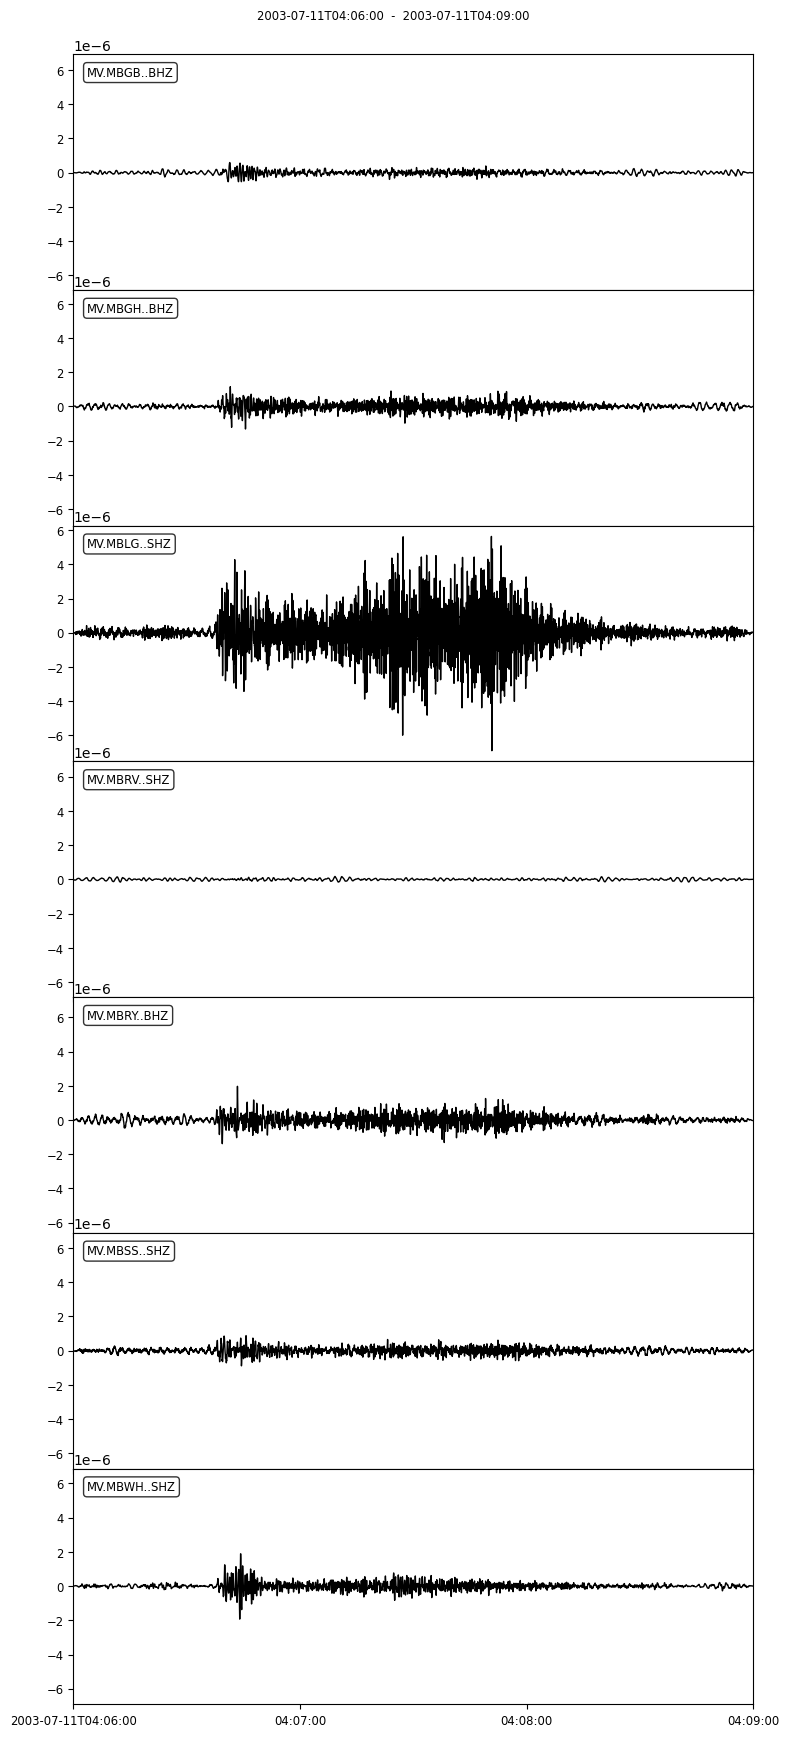

In [16]:

from obspy.clients.filesystem.sds import Client

sdsclient = Client(SDS_DIR)
starttpf = obspy.UTCDateTime(2003,7,11,4,6,0)
endtpf = obspy.UTCDateTime(2003,7,11,4,9,0)
stpf = sdsclient.get_waveforms("MV", "*", "", "*Z", starttpf, endtpf)

# Load inventory
invpf = obspy.read_inventory(os.path.join(RESPONSE_DIR,'MV.xml'), format='stationxml')
invpf = invMVO.select(starttime=startt, endtime=endt)
invpf = invMVO.select(channel='*Z')
print(invpf)

# remove instrument response - and set units accordingly IMPORTANT!
pre_filt = [0.4, 0.5, 18, 20]
#pre_filt = [6.0, 7.0, 9.0, 10.0]
for tr in stpf:
    print(tr)
    try:
        tr.remove_response(inventory=invpf, pre_filt=pre_filt, output="DISP", plot=False) 
    except:
        stpf.remove(tr)
    else:
        tr.stats['units'] = 'm'
stpf.plot(equal_scale=True);


NOTE: 'squash_nans' is deprecated; SAM now always uses NaN-aware reducers.
METRIC: rms


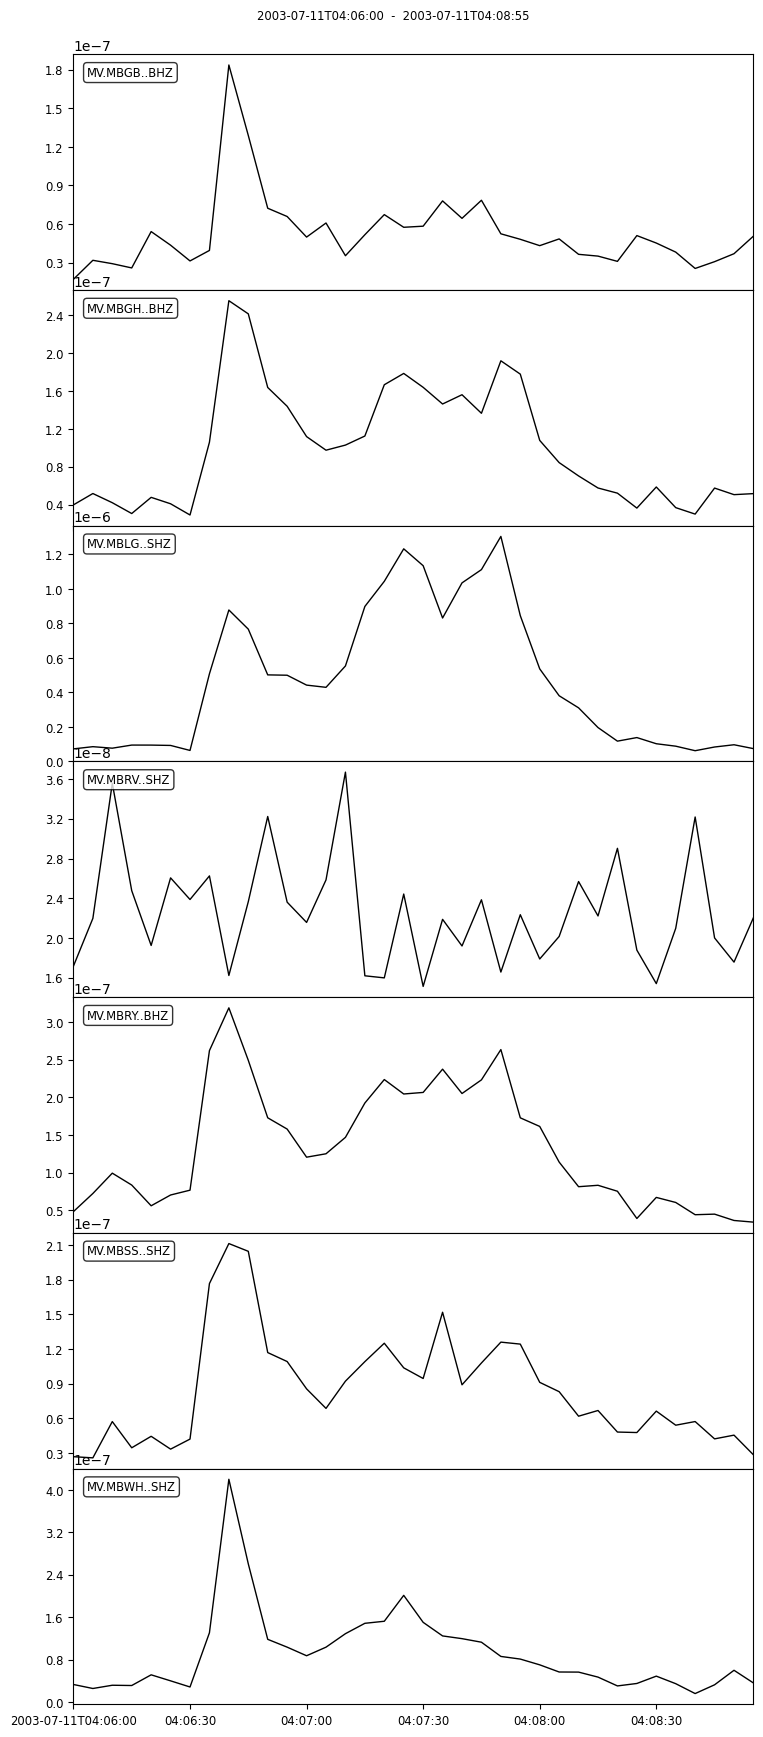

In [17]:

# compute DSAM data with 10-s time window
dsamObjpf = DSAM(stream=stpf, sampling_interval=5)
#print(dsamObj)
dsamObjpf.plot(metrics='rms', equal_scale=False)

In [ ]:

# same parameters as before
Q = 23
surfaceWaveSpeed_kms = 1.5 # km/s
peakf = 8.0

# denser grid than before
source = {'lat':16.71111, 'lon':-62.17722}
#node_spacing_m = 20
node_spacing_m = 10 
grid_size_lat_m = 10000
grid_size_lon_m = 10000
nlat = int(grid_size_lat_m/node_spacing_m) + 1
nlon = int(grid_size_lon_m/node_spacing_m) + 1
gridobj = Grid(source['lat'], source['lon'], nlat, nlon, node_spacing_m)  

SCAFFOLD: Inventory created at 2024-01-11T03:20:26.394930Z
	Created by: ObsPy 1.4.0
		    https://www.obspy.org
	Sending institution: ObsPy's obspy.io.xseed version 1.2.2
	Contains:
		Networks (13):
			MV (13x)
		Stations (13):
			MV.MBBE ()
			MV.MBBY ()
			MV.MBGA ()
			MV.MBGB ()
			MV.MBGE ()
			MV.MBGH ()
			MV.MBLG ()
			MV.MBLY ()
			MV.MBMH ()
			MV.MBRV ()
			MV.MBRY ()
			MV.MBSS ()
			MV.MBWH ()
		Channels (13):
			MV.MBBE..BHZ, MV.MBBY..BHZ, MV.MBGA..BHZ, MV.MBGB..BHZ, 
			MV.MBGE..BHZ, MV.MBGH..BHZ, MV.MBLG..SHZ, MV.MBLY..HHZ, 
			MV.MBMH..SHZ, MV.MBRV..SHZ, MV.MBRY..BHZ, MV.MBSS..SHZ, 
			MV.MBWH..SHZ
SCAFFOLD: Inventory created at 2024-01-11T03:20:26.394930Z
	Created by: ObsPy 1.4.0
		    https://www.obspy.org
	Sending institution: ObsPy's obspy.io.xseed version 1.2.2
	Contains:
		Networks (13):
			MV (13x)
		Stations (13):
			MV.MBBE ()
			MV.MBBY ()
			MV.MBGA ()
			MV.MBGB ()
			MV.MBGE ()
			MV.MBGH ()
			MV.MBLG ()
			MV.MBLY ()
			MV.MBMH ()
			MV.MBRV ()
			MV.MBR

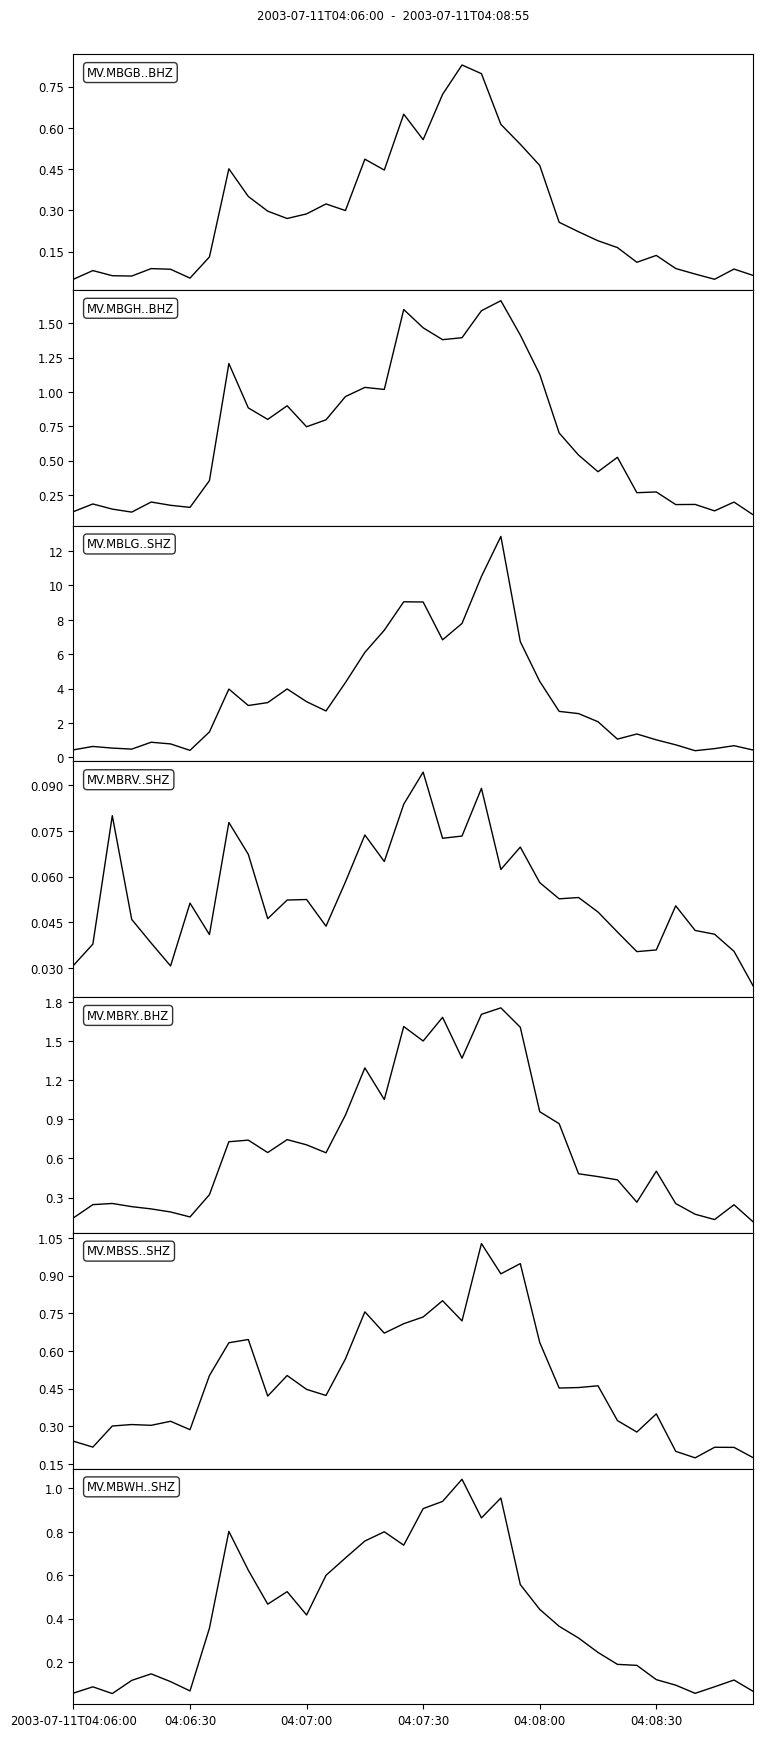

In [19]:
# Reduced displacement if source was at dome
DRSobjpf = dsamObjpf.compute_reduced_displacement(invpf, source, surfaceWaves=True, Q=None, wavespeed_kms=1.5)
DRSobjpf.plot(equal_scale=False, metrics=['VT'])

In [20]:
aslobjpf = ASL(dsamObjpf, 'VT', invpf, gridobj, window_seconds=5)

aslobjpf.compute_grid_distances()

aslobjpf.compute_amplitude_corrections(surfaceWaves=True, wavespeed_kms=surfaceWaveSpeed_kms, Q=None, fix_peakf = peakf)


[INFO] Computing distances using 13 channels from inventory.
[DONE] Grid distances computed for 13 trace IDs.
[CACHE HIT] Loaded amplitude corrections from asl_cache/ampcorr_Q99_V2_f8_surf.pkl


{'DR': array([100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100.]),
 'azgap': array([137.51246964, 138.94863183, 136.96238166, 131.71221342,
       122.28574562, 107.15420896, 121.12607227, 153.9654535 ,
       114.46199549, 117.79928201, 117.09066723, 112.85892607,
       105.02484985,  93.49073516, 108.49371229, 132.71000362,
        96.73170451, 100.4709479 , 100.5984563 ,  97.54667179,
        91.56478282,  82.994017  ,  92.5928968 , 107.27307057,
        83.23260543,  86.65994536,  87.2106088 ,  85.14052063,
        86.04991686,  93.93496972, 101.87354099, 112.19809578,
        72.78814641,  75.69942965,  76.41234934,  8

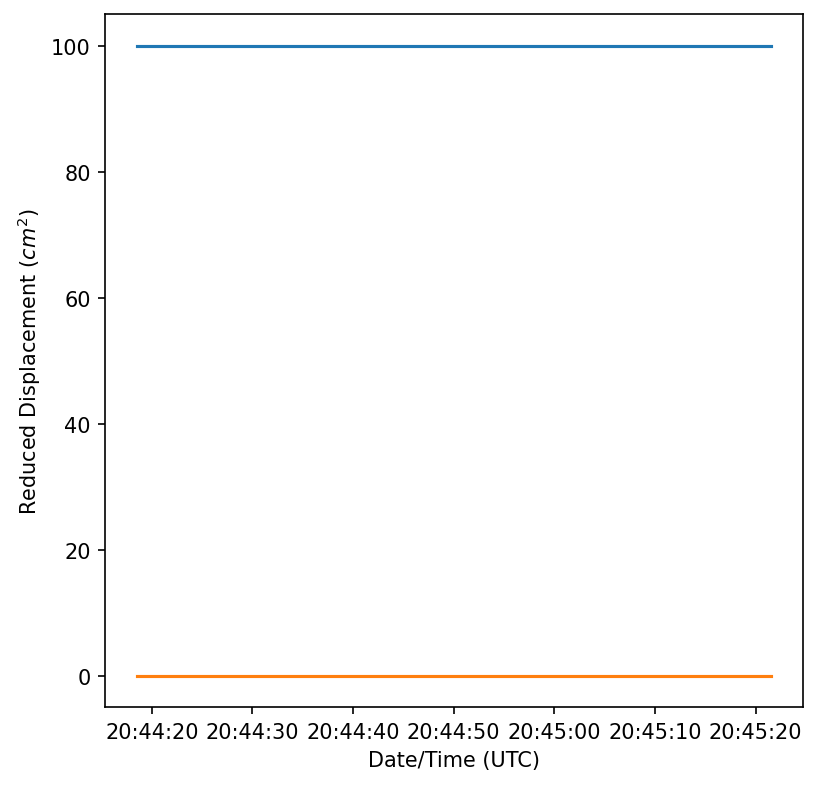

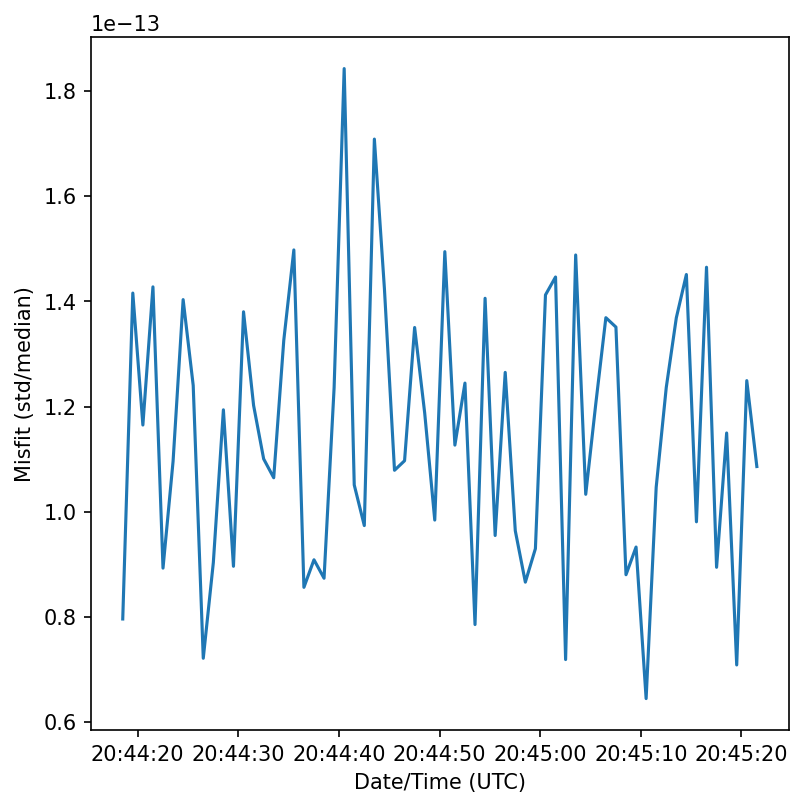

topo_map: region=[np.float64(-62.29375887814026), np.float64(-62.154578889807006), np.float64(16.5994772530374), np.float64(16.732810586370732)]


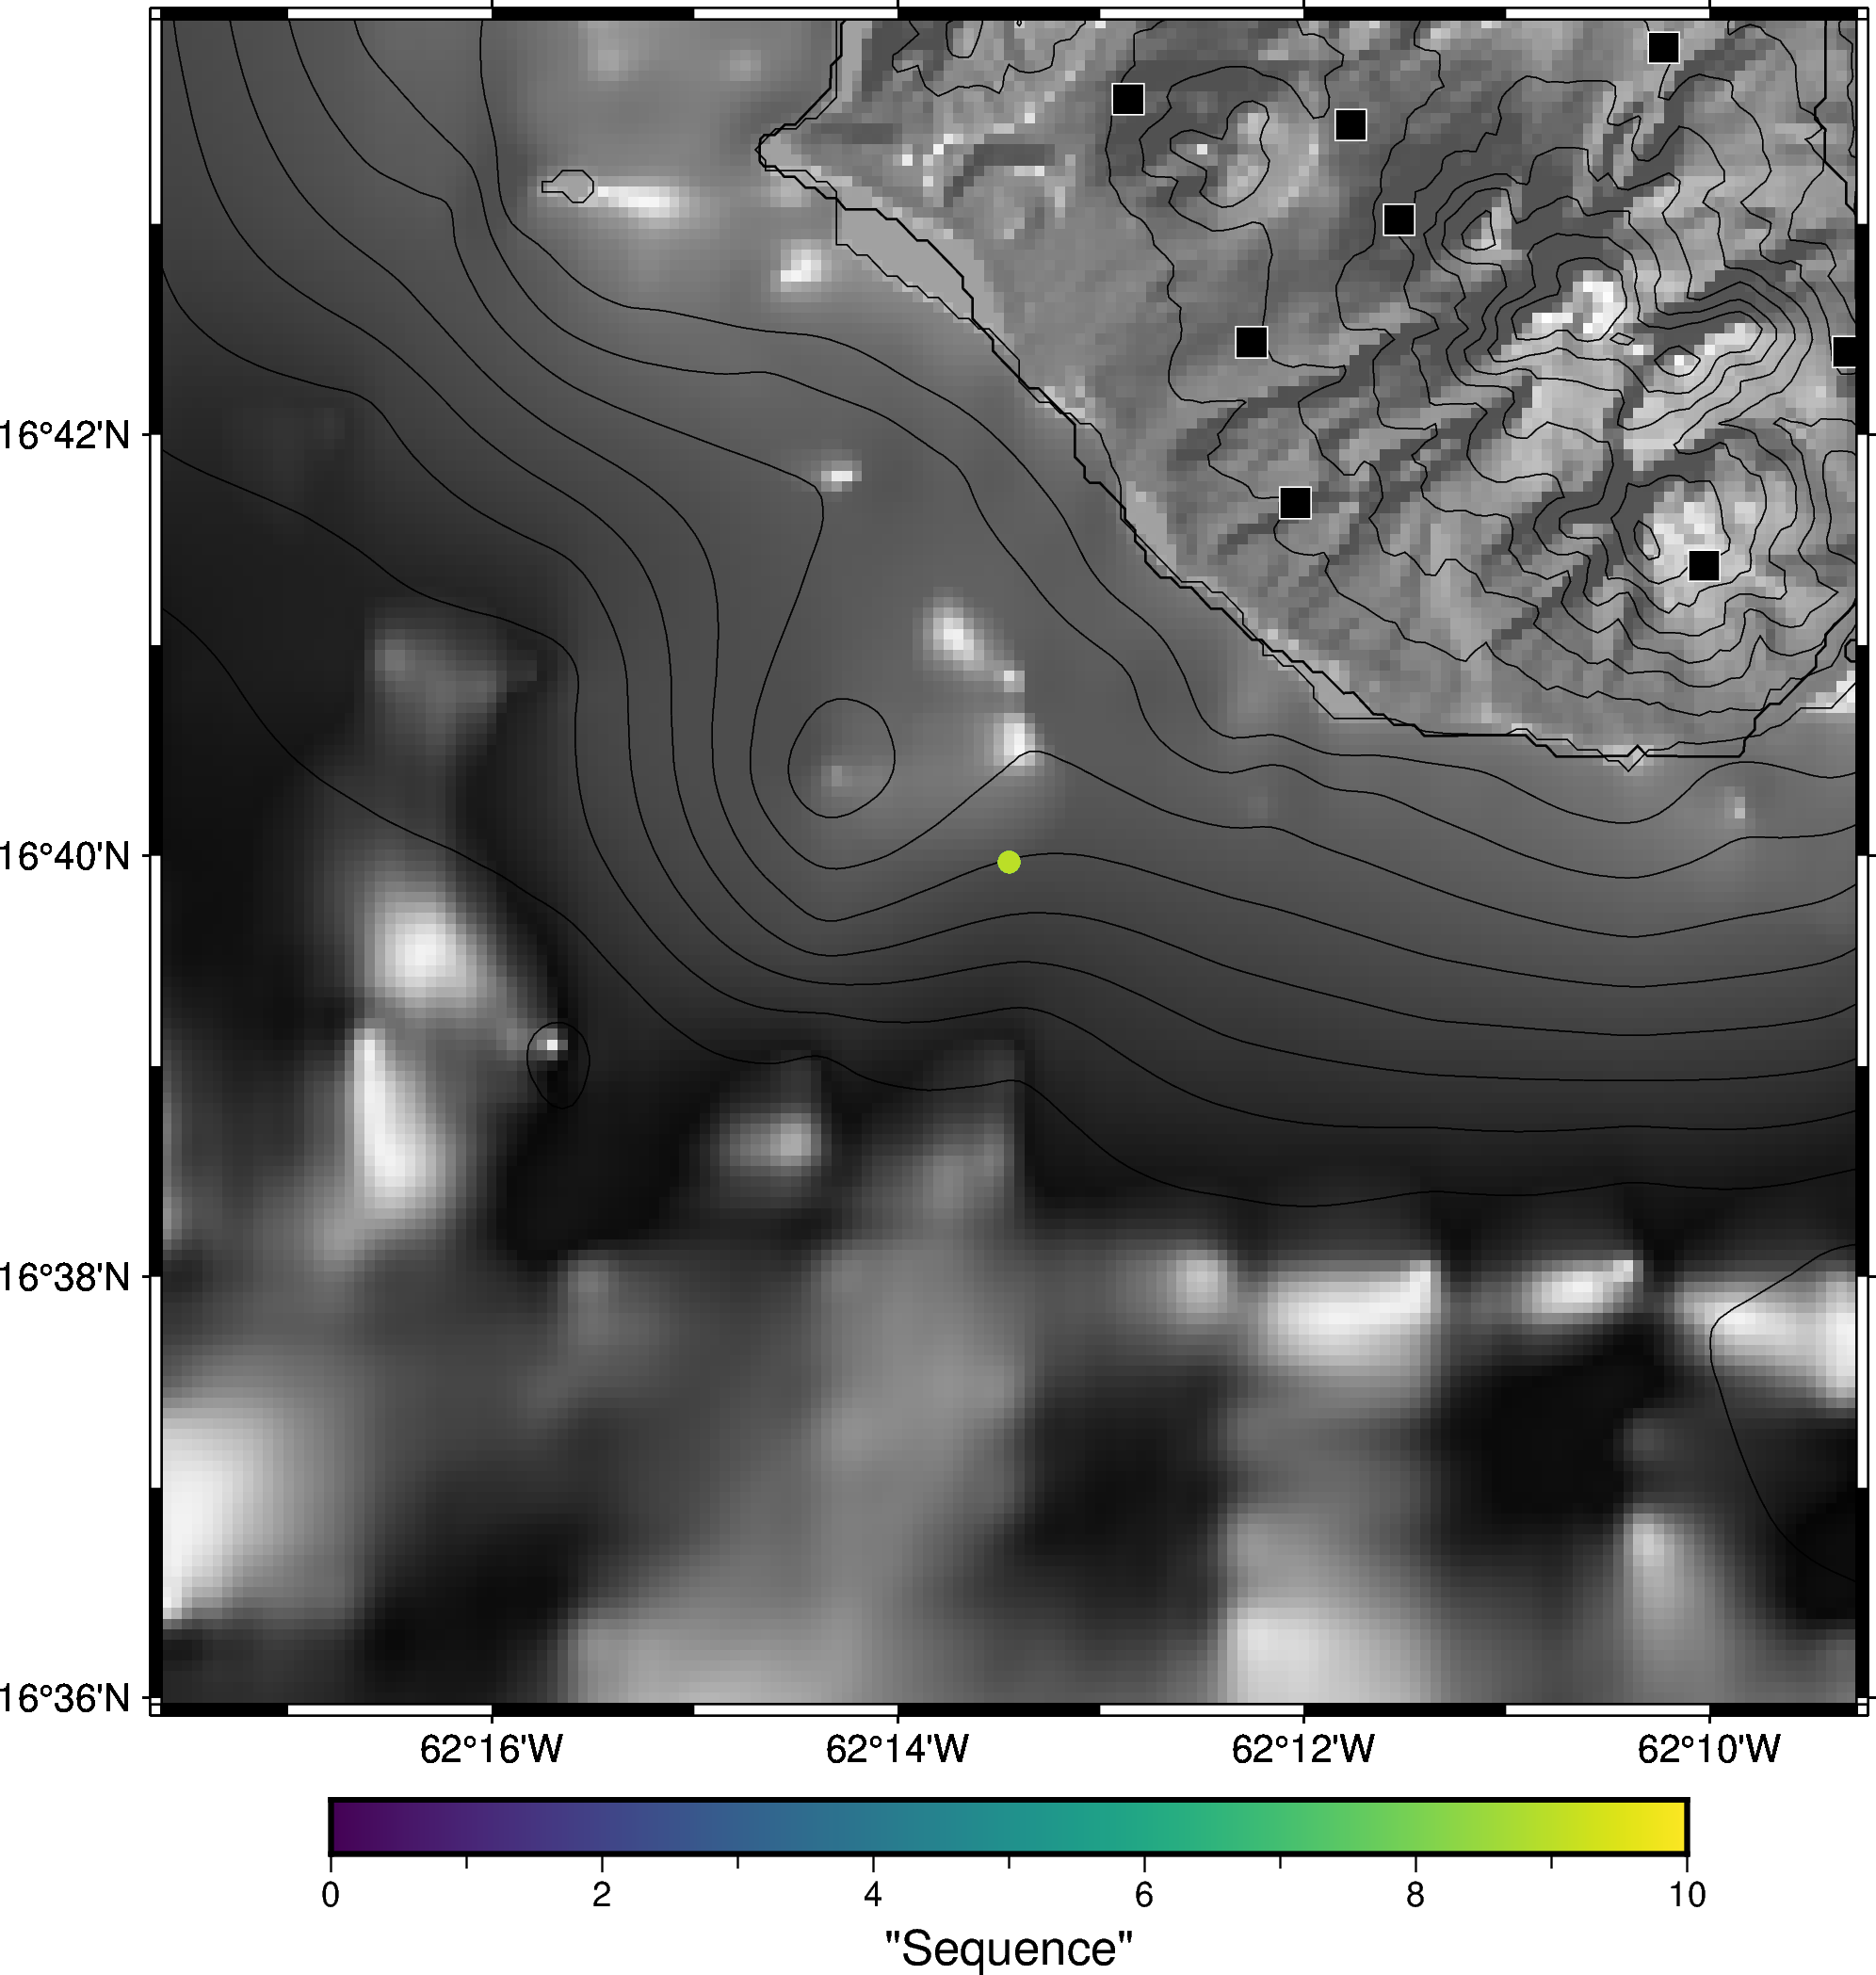

plot [WARNING]: - not a valid number and may not be decoded properly.


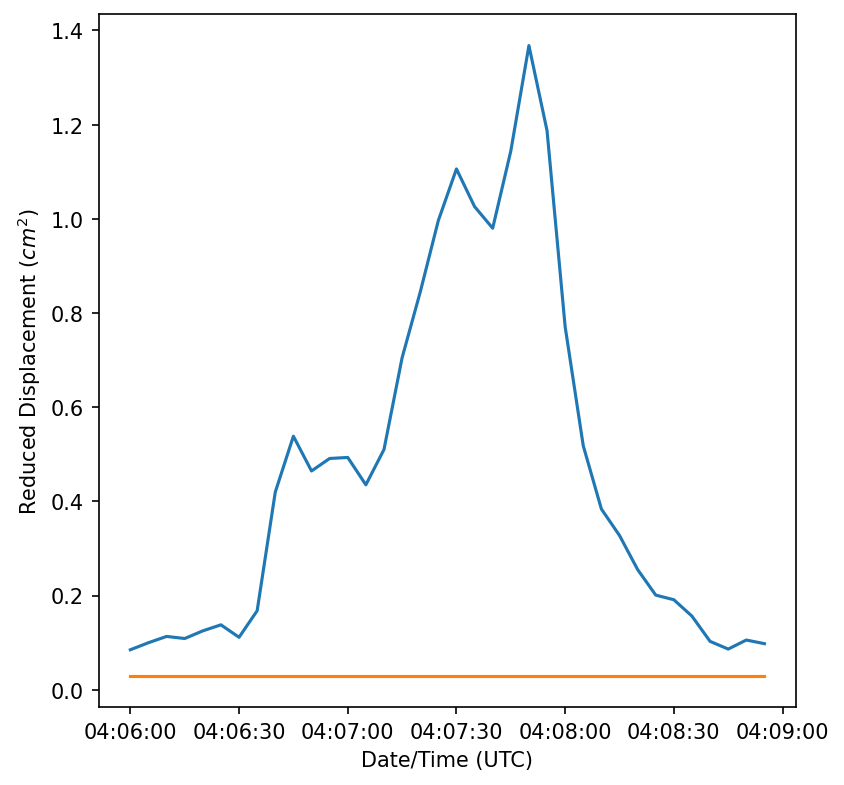

In [21]:
aslobjpf.fast_locate()
aslobj.print_source()
aslobj.plot_reduced_displacement()
aslobj.plot_misfit()
aslobjpf.plot(zoom_level=1, threshold_DR=0.03, scale=0.2, join=True, number=10, equal_size=True, add_labels=False)